In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data_path = '/home/mvkrein/etf_model/data'
etf_data_file = os.path.join(data_path,'etf_new_var_20180910.csv')
etf_data = pd.read_csv(etf_data_file,index_col=0)

In [4]:
etf_study_file = os.path.join(data_path,'ETF_list_min_6yr_history.csv')
etf_list = pd.read_csv(etf_study_file,index_col=0)
etf_data.sort_values(['Date','sym'],ascending=True,inplace=True)
etf_data.reset_index(drop=True,inplace=True)

In [5]:
drop_columns = ['Date','sym','p', 'v', 'p_L05', 'v_L05', 'p_L10', 'v_L10', 'p_L21', 'v_L21', 'p_L42', 'v_L42', 'p_L63', \
                'v_L63', 'p_L84', 'v_L84', 'p_L126', 'v_L126', 'p_L189', 'v_L189', 'p_L252', 'v_L252',\
                'p_L-21', 'v_L-21', 'delta_p_L05', 'delta_p_L10', 'delta_p_L21', 'delta_p_L42', 'delta_p_L63', \
                'delta_p_L84', 'delta_p_L126', 'delta_p_L189', 'delta_p_L252', 'delta_p_L-21', 'delta_v_L05',\
                'delta_v_L10', 'delta_v_L21', 'delta_v_L42', 'delta_v_L63', 'delta_v_L84', 'delta_v_L126', \
                'delta_v_L189', 'delta_v_L252','rank_p_L-21', 'ivv_delta_p_L-21', 'target']

rank_col = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
            'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']

In [6]:
all_columns = list(etf_data.columns)

In [7]:
include_columns = [x for x in all_columns if x not in drop_columns]
# include_columns = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
#             'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']
# include_columns = ['rank_p_L05','rank_p_L21','rank_p_L42','rank_p_L252']

In [8]:
len(include_columns)

360

In [9]:
dates = list(etf_data['Date'].unique())
# dates[1671]

In [10]:
symbols = etf_list['Symbol'].unique()

In [11]:
len(symbols)

153

In [12]:
#Each year has 252 trading dates.  Need two years to fully develop variables.
dt1 = 504 #This is the first day that all variables are developed
# dt1 = 504 + 21 + 273 #This is the first day that all variables are developed 2016-04-07
# make all dates relative to dt1
# for one year training - add 252
# to evaluate for one month outside the training window - add 273
# to predict for the first day outside of the evaluation window (have to lag 21) - add 294
dt_end = (len(dates) - 273 - 21) - 1
# dt_end = dt1 + 1
# etf_predict_file = os.path.join(data_path,'etf_pred_linear_pca_with_poly_20180929.csv')
k=0

In [13]:

for i in range(dt1,dt_end):
    print("Building model to predict for ",dates[i+273])
    x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
    y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']] #train with 12 mos

    x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns]#predict one day-must be 21 days removed from training
    y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['rank_p_L-21']] #predict if etf >= market
    returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
    mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
    x_train_nmpy = x_train.as_matrix()
    y_train_nmpy = np.ravel(y_train.as_matrix())

    x_test_nmpy = x_test.as_matrix()
    y_test_nmpy = np.ravel(y_test.as_matrix())
    returns_nmpy = returns.as_matrix()
    mkt_return_nmpy = mkt_return.as_matrix()
    
    pca = PCA(n_components = 14)
    pca.fit(x_train_nmpy)

    print(pca.explained_variance_ratio_)
    print('Total variance captured = ',round(sum(pca.explained_variance_ratio_),4))

    x_train_new = pca.transform(x_train_nmpy)
    x_test_new = pca.transform(x_test_nmpy)

    poly = PolynomialFeatures(degree=3)
    x_train_poly = poly.fit_transform(x_train_new)
    x_test_poly = poly.fit_transform(x_test_new)

    lm = LinearRegression(n_jobs=32)

    lm.fit(x_train_poly, y_train_nmpy)

    y_pred_model = lm.predict(x_test_poly)
    y_train_model = lm.predict(x_train_poly)

    y_check = np.column_stack((y_test_nmpy, y_pred_model,mkt_return_nmpy,returns_nmpy))
    y_check_df = pd.DataFrame(y_check,columns=['true_value','pred_value','mkt_return','returns'])
    y_check_df.sort_values('pred_value',inplace=True,ascending=False)


    train_error = mean_squared_error(y_train_nmpy,y_train_model)
    eval_error = mean_squared_error(y_test_nmpy,y_pred_model)

    print('Model Eval Results:')
    print('*****************************')

    print(f'training error: {train_error:.3}')
    print(f'evaluation error: {eval_error:.3}')
    print('R-squared score (training): {:.3f}'
     .format(r2_score(y_train_nmpy, y_train_model)))
    print('R-squared score (test): {:.3f}'
     .format(r2_score(y_test_nmpy, y_pred_model)))

    print('*****************************')
    print("Model Top 5 Picks")
    print(" Avg rtn top 5:", round(y_check_df['returns'][0:5].mean(),4))
    print(y_check_df.head(5))
    print("Model Bottom 5 Picks")
    print(" Avg rtn bottom 5:", round(y_check_df['returns'][-5:].mean(),4))
    print(y_check_df.tail(5))
    print('********************************************************')
    etf_predict_file = os.path.join(data_path,('etf_pred_linear_pca_poly3_20180920_'+str(k%21)+'.csv'))
    if k < 21:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file)
    else:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file,header=False,mode='a')
    k+=1

Building model to predict for  2015-02-05
[0.50534149 0.16456856 0.07525326 0.05501668 0.03866326 0.02287851
 0.02010547 0.01540546 0.01241954 0.01099241 0.00929365 0.00797082
 0.00671036 0.0057639 ]
Total variance captured =  0.9504
Model Eval Results:
*****************************
training error: 0.0441
evaluation error: 0.107
R-squared score (training): 0.471
R-squared score (test): -0.280
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0107
     true_value  pred_value  mkt_return   returns
104    0.869281    1.168402    0.010741  0.026336
60     0.189542    1.063367    0.010741 -0.029528
24     0.915033    0.991502    0.010741  0.040593
121    0.745098    0.991311    0.010741  0.012149
38     0.627451    0.987222    0.010741  0.004112
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0516
     true_value  pred_value  mkt_return   returns
49     0.150327   -0.217698    0.010741 -0.036237
18     0.215686   -0.319843    0.010741 -0.025901
55     0.006536   -0.348597    0.01

[0.504016   0.1656757  0.0747291  0.05501318 0.03898079 0.02277996
 0.02135604 0.01528315 0.01193485 0.01100012 0.00901321 0.00799997
 0.00676806 0.00582606]
Total variance captured =  0.9504
Model Eval Results:
*****************************
training error: 0.0442
evaluation error: 0.21
R-squared score (training): 0.469
R-squared score (test): -1.514
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0041
     true_value  pred_value  mkt_return   returns
38     0.934641    1.610985    0.001134  0.030981
58     0.568627    1.454855    0.001134  0.007825
24     0.888889    1.384301    0.001134  0.023465
33     0.542484    1.349743    0.001134  0.006620
148    0.026144    1.349066    0.001134 -0.089157
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0141
     true_value  pred_value  mkt_return   returns
18     0.274510   -0.020783    0.001134 -0.004942
23     0.267974   -0.110949    0.001134 -0.005451
70     1.000000   -0.198587    0.001134  0.095833
143    0.202614   -0.247116 

[0.5016382  0.16595405 0.07516529 0.05507409 0.03884012 0.02315361
 0.02309587 0.01516854 0.01189884 0.01101824 0.00816952 0.00798519
 0.00687476 0.00612898]
Total variance captured =  0.9502
Model Eval Results:
*****************************
training error: 0.0436
evaluation error: 0.143
R-squared score (training): 0.477
R-squared score (test): -0.716
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0194
     true_value  pred_value  mkt_return   returns
148    0.019608    1.713289   -0.022652 -0.096837
138    0.954248    1.300161   -0.022652  0.023990
38     0.921569    1.271420   -0.022652  0.017580
62     0.052288    1.249851   -0.022652 -0.046951
58     0.790850    1.140167   -0.022652  0.005153
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0196
     true_value  pred_value  mkt_return   returns
143    0.084967    0.126996   -0.022652 -0.039462
118    0.065359    0.006979   -0.022652 -0.042256
99     0.032680   -0.007990   -0.022652 -0.055487
70     0.928105   -0.01043

[0.50017301 0.16477793 0.07527249 0.05598141 0.03859832 0.02498326
 0.02343258 0.01504051 0.01182758 0.011086   0.00814669 0.00726599
 0.0068999  0.00626783]
Total variance captured =  0.9498
Model Eval Results:
*****************************
training error: 0.0433
evaluation error: 0.0707
R-squared score (training): 0.480
R-squared score (test): 0.151
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.1056
     true_value  pred_value  mkt_return   returns
148    0.771242    1.179779     0.00266  0.045663
60     0.993464    0.947031     0.00266  0.179205
126    0.986928    0.922062     0.00266  0.178278
53     0.738562    0.881466     0.00266  0.042591
39     0.928105    0.872002     0.00266  0.082243
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.005
     true_value  pred_value  mkt_return   returns
118    0.006536    0.257571     0.00266 -0.030231
117    0.052288    0.253003     0.00266 -0.008896
70     0.522876    0.217613     0.00266  0.026657
67     0.189542    0.191055  

Model Eval Results:
*****************************
training error: 0.0423
evaluation error: 0.121
R-squared score (training): 0.492
R-squared score (test): -0.449
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0342
    true_value  pred_value  mkt_return   returns
60    0.993464    0.980070   -0.007277  0.159175
40    0.718954    0.946952   -0.007277  0.024845
79    0.535948    0.929610   -0.007277  0.007362
99    0.013072    0.877746   -0.007277 -0.034663
33    0.647059    0.869600   -0.007277  0.014467
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0617
    true_value  pred_value  mkt_return   returns
59    0.359477    0.162973   -0.007277  0.000415
14    0.941176    0.141973   -0.007277  0.083889
41    0.627451    0.127177   -0.007277  0.013323
62    0.901961    0.115057   -0.007277  0.066971
32    0.980392   -0.011612   -0.007277  0.144061
********************************************************
Building model to predict for  2015-03-19
[0.49953554 0.16306193 0.07612433

[0.49849227 0.16340688 0.07717838 0.05539106 0.03878866 0.02523741
 0.02328044 0.01537317 0.01363911 0.01067465 0.00798896 0.00731431
 0.00715739 0.00556963]
Total variance captured =  0.9495
Model Eval Results:
*****************************
training error: 0.0425
evaluation error: 0.192
R-squared score (training): 0.489
R-squared score (test): -1.299
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0289
    true_value  pred_value  mkt_return   returns
79    0.450980    1.239445    0.011306  0.009473
50    0.836601    1.037261    0.011306  0.061509
42    0.620915    0.980636    0.011306  0.022196
89    0.058824    0.961314    0.011306 -0.024901
53    0.895425    0.938484    0.011306  0.076068
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.1162
    true_value  pred_value  mkt_return   returns
11    0.954248   -0.015895    0.011306  0.123288
14    0.843137   -0.111997    0.011306  0.062453
55    0.967320   -0.118963    0.011306  0.152700
62    0.921569   -0.274691    0.011306

Model Eval Results:
*****************************
training error: 0.0429
evaluation error: 0.37
R-squared score (training): 0.485
R-squared score (test): -3.525
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0059
    true_value  pred_value  mkt_return   returns
79    0.490196    1.912071    0.012837  0.003304
28    0.045752    1.402485    0.012837 -0.045327
89    0.065359    1.396874    0.012837 -0.025369
50    0.901961    1.393487    0.012837  0.037879
80    0.411765    1.383490    0.012837  0.000000
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.044
     true_value  pred_value  mkt_return   returns
101    0.973856   -0.036611    0.012837  0.076000
46     0.967320   -0.109761    0.012837  0.070552
143    0.032680   -0.262425    0.012837 -0.047139
117    0.888889   -0.271532    0.012837  0.033562
62     0.986928   -0.560494    0.012837  0.087110
********************************************************
Building model to predict for  2015-04-10
[0.49668723 0.16432295 0.077

[0.49526397 0.16456001 0.07697579 0.05586403 0.04022543 0.02537727
 0.02311731 0.01564165 0.01322321 0.01069177 0.00804788 0.00733769
 0.00728809 0.00561665]
Total variance captured =  0.9492
Model Eval Results:
*****************************
training error: 0.0431
evaluation error: 0.158
R-squared score (training): 0.482
R-squared score (test): -0.897
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0067
    true_value  pred_value  mkt_return   returns
79    0.751634    1.684905    0.015304  0.020564
99    0.359477    1.156987    0.015304 -0.000327
88    0.124183    1.051389    0.015304 -0.018564
42    0.901961    1.027645    0.015304  0.039239
30    0.254902    1.008214    0.015304 -0.007256
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0219
     true_value  pred_value  mkt_return   returns
85     0.326797   -0.108360    0.015304 -0.002296
141    0.333333   -0.141424    0.015304 -0.001663
102    0.705882   -0.182855    0.015304  0.018089
101    0.986928   -0.351149    0.0

Model Eval Results:
*****************************
training error: 0.0429
evaluation error: 0.134
R-squared score (training): 0.485
R-squared score (test): -0.609
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0149
     true_value  pred_value  mkt_return   returns
139    0.986928    1.579468    0.014772  0.089646
71     0.640523    1.295573    0.014772  0.010089
133    0.705882    1.182716    0.014772  0.014089
118    0.228758    1.147956    0.014772 -0.020912
79     0.261438    1.128958    0.014772 -0.018594
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0254
     true_value  pred_value  mkt_return   returns
17     0.490196   -0.380580    0.014772 -0.002348
138    0.960784   -0.383715    0.014772  0.036941
11     0.130719   -0.395535    0.014772 -0.039852
32     0.019608   -0.413969    0.014772 -0.076923
16     0.104575   -0.416035    0.014772 -0.044776
********************************************************
Building model to predict for  2015-05-01
[0.49144351 0.163864

[0.48681825 0.16295865 0.0738784  0.0697435  0.03953236 0.02575592
 0.02363155 0.01529504 0.01289242 0.01098036 0.00823039 0.00715231
 0.00680546 0.00563372]
Total variance captured =  0.9493
Model Eval Results:
*****************************
training error: 0.0426
evaluation error: 0.161
R-squared score (training): 0.488
R-squared score (test): -0.930
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0173
     true_value  pred_value  mkt_return   returns
79     0.483660    1.346087    0.008233 -0.004606
146    0.326797    1.256883    0.008233 -0.013649
99     0.215686    1.226863    0.008233 -0.025755
98     0.333333    1.142606    0.008233 -0.013489
133    0.196078    1.117607    0.008233 -0.028956
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0583
    true_value  pred_value  mkt_return   returns
29    0.065359   -0.123676    0.008233 -0.059328
51    0.287582   -0.136111    0.008233 -0.018868
14    0.013072   -0.269763    0.008233 -0.086738
46    0.274510   -0.369250    

[0.48760707 0.16138164 0.07327148 0.07214232 0.03927744 0.0259225
 0.02338192 0.01530077 0.01336156 0.01079207 0.00826669 0.00715294
 0.00675525 0.00563387]
Total variance captured =  0.9502
Model Eval Results:
*****************************
training error: 0.0415
evaluation error: 0.105
R-squared score (training): 0.501
R-squared score (test): -0.277
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0122
     true_value  pred_value  mkt_return   returns
139    0.875817    1.110426   -0.002513  0.013664
118    0.568627    1.065856   -0.002513 -0.006974
71     0.209150    1.028412   -0.002513 -0.028649
99     0.483660    1.021143   -0.002513 -0.010174
146    0.202614    0.992302   -0.002513 -0.028654
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0408
     true_value  pred_value  mkt_return   returns
51     0.294118    0.149409   -0.002513 -0.022110
46     0.320261    0.121574   -0.002513 -0.020821
138    0.065359    0.093806   -0.002513 -0.054911
11     0.137255    0.083365

[0.48607107 0.16045384 0.07751207 0.07344849 0.03853943 0.02580301
 0.02289402 0.01528743 0.01329882 0.01045767 0.00809123 0.00711224
 0.00684785 0.00566467]
Total variance captured =  0.9515
Model Eval Results:
*****************************
training error: 0.0417
evaluation error: 0.123
R-squared score (training): 0.499
R-squared score (test): -0.478
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0078
     true_value  pred_value  mkt_return   returns
54     0.385621    1.213088   -0.013083 -0.021933
99     0.973856    1.211112   -0.013083  0.025254
104    0.980392    1.061047   -0.013083  0.032971
23     0.039216    1.049054   -0.013083 -0.071953
88     0.790850    0.990738   -0.013083 -0.003345
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0708
     true_value  pred_value  mkt_return   returns
39     0.189542    0.144454   -0.013083 -0.035151
11     0.143791    0.132586   -0.013083 -0.041280
15     0.006536    0.119791   -0.013083 -0.140183
126    0.045752    0.00950

[0.48461626 0.15989045 0.08011285 0.07383625 0.03820494 0.02703174
 0.02282801 0.0150821  0.01334541 0.01027649 0.00792911 0.00706517
 0.00685618 0.00564492]
Total variance captured =  0.9527
Model Eval Results:
*****************************
training error: 0.0416
evaluation error: 0.124
R-squared score (training): 0.500
R-squared score (test): -0.492
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0116
     true_value  pred_value  mkt_return   returns
32     0.189542    1.146041   -0.003901 -0.028345
104    0.993464    1.003799   -0.003901  0.050873
25     0.934641    0.944256   -0.003901  0.013861
103    0.542484    0.894196   -0.003901 -0.007619
88     0.973856    0.893477   -0.003901  0.029060
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0472
     true_value  pred_value  mkt_return   returns
101    0.019608    0.004783   -0.003901 -0.109957
54     0.418301   -0.053078   -0.003901 -0.013084
31     0.254902   -0.098056   -0.003901 -0.021081
62     0.052288   -0.098228

Model Eval Results:
*****************************
training error: 0.0408
evaluation error: 0.127
R-squared score (training): 0.509
R-squared score (test): -0.519
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0406
    true_value  pred_value  mkt_return   returns
14    0.215686    0.954230   -0.002813 -0.044272
25    0.764706    0.892118   -0.002813  0.001563
17    0.143791    0.871818   -0.002813 -0.064852
32    0.150327    0.769577   -0.002813 -0.062399
3     0.287582    0.768116   -0.002813 -0.033215
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0771
     true_value  pred_value  mkt_return   returns
31     0.130719   -0.205635   -0.002813 -0.073787
101    0.078431   -0.278123   -0.002813 -0.086959
148    0.209150   -0.338172   -0.002813 -0.046007
54     0.052288   -0.378968   -0.002813 -0.090051
55     0.058824   -0.672254   -0.002813 -0.088920
********************************************************
Building model to predict for  2015-06-23
[0.48407527 0.1581657  0.

[0.48547213 0.15506907 0.08318709 0.07349069 0.03896566 0.03040474
 0.02261387 0.01461108 0.01310924 0.01003085 0.00792108 0.0070776
 0.00682174 0.00548496]
Total variance captured =  0.9543
Model Eval Results:
*****************************
training error: 0.0401
evaluation error: 0.21
R-squared score (training): 0.518
R-squared score (test): -1.514
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0481
    true_value  pred_value  mkt_return   returns
32    0.098039    1.534162    0.011745 -0.092219
46    0.784314    1.230587    0.011745  0.018114
85    0.542484    1.015150    0.011745  0.004820
97    0.058824    0.963113    0.011745 -0.102744
14    0.169935    0.949805    0.011745 -0.068674
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0027
     true_value  pred_value  mkt_return   returns
99     0.470588   -0.043300    0.011745  0.001644
129    0.764706   -0.077854    0.011745  0.017273
148    0.137255   -0.122652    0.011745 -0.072606
120    0.705882   -0.270561    0.0

[0.48684737 0.15369287 0.08431002 0.07236005 0.03883918 0.03077198
 0.02261513 0.01468391 0.01349563 0.00977592 0.0078632  0.00711787
 0.00673643 0.0054759 ]
Total variance captured =  0.9546
Model Eval Results:
*****************************
training error: 0.0393
evaluation error: 0.159
R-squared score (training): 0.527
R-squared score (test): -0.912
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0271
     true_value  pred_value  mkt_return   returns
46     0.581699    1.208942   -0.008868 -0.009768
44     0.032680    1.040942   -0.008868 -0.123660
123    0.287582    0.976314   -0.008868 -0.032726
85     0.947712    0.913956   -0.008868  0.022519
138    0.862745    0.896969   -0.008868  0.008163
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0513
     true_value  pred_value  mkt_return   returns
39     0.215686   -0.143016   -0.008868 -0.048704
117    0.601307   -0.177670   -0.008868 -0.008885
60     0.156863   -0.345567   -0.008868 -0.063437
126    0.176471   -0.39890

Model Eval Results:
*****************************
training error: 0.0395
evaluation error: 0.0958
R-squared score (training): 0.525
R-squared score (test): -0.149
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0417
    true_value  pred_value  mkt_return   returns
46    0.581699    0.985035   -0.059961 -0.048289
85    0.980392    0.890868   -0.059961  0.030469
37    0.411765    0.873000   -0.059961 -0.061199
40    0.522876    0.861082   -0.059961 -0.054945
33    0.300654    0.849792   -0.059961 -0.074778
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.1463
     true_value  pred_value  mkt_return   returns
39     0.098039    0.048536   -0.059961 -0.134342
11     0.124183   -0.203027   -0.059961 -0.127097
15     0.013072   -0.322262   -0.059961 -0.189016
60     0.084967   -0.327357   -0.059961 -0.135697
126    0.045752   -0.383455   -0.059961 -0.145186
********************************************************
Building model to predict for  2015-07-24
[0.48734382 0.15293143 0

Model Eval Results:
*****************************
training error: 0.0391
evaluation error: 0.0615
R-squared score (training): 0.530
R-squared score (test): 0.261
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0453
     true_value  pred_value  mkt_return   returns
72     0.098039    0.971437   -0.086761 -0.127863
46     0.686275    0.874837   -0.086761 -0.065031
85     0.986928    0.860661   -0.086761  0.015187
102    0.993464    0.812819   -0.086761  0.023024
133    0.620915    0.785575   -0.086761 -0.071736
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.1513
     true_value  pred_value  mkt_return   returns
39     0.045752    0.056417   -0.086761 -0.143641
11     0.091503    0.010188   -0.086761 -0.129013
126    0.039216   -0.122140   -0.086761 -0.145960
60     0.065359   -0.128919   -0.086761 -0.140637
15     0.006536   -0.247812   -0.086761 -0.197130
********************************************************
Building model to predict for  2015-08-04
[0.48787455 0.15128

[0.48869717 0.1481365  0.08756292 0.07219539 0.03746704 0.03303969
 0.02244582 0.01476163 0.0145768  0.00946872 0.00788977 0.0077117
 0.00643997 0.00511519]
Total variance captured =  0.9555
Model Eval Results:
*****************************
training error: 0.0391
evaluation error: 0.0877
R-squared score (training): 0.529
R-squared score (test): -0.052
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0566
     true_value  pred_value  mkt_return   returns
72     0.098039    0.937292   -0.060824 -0.087549
133    0.274510    0.917719   -0.060824 -0.068500
89     0.692810    0.853975   -0.060824 -0.038551
104    0.803922    0.833859   -0.060824 -0.014655
71     0.222222    0.820905   -0.060824 -0.073725
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0907
    true_value  pred_value  mkt_return   returns
62    0.751634    0.179876   -0.060824 -0.024543
60    0.032680    0.164643   -0.060824 -0.107665
11    0.091503    0.164004   -0.060824 -0.088306
78    0.124183    0.111577   -

[0.49112318 0.14414922 0.08700024 0.07355299 0.03685739 0.03519646
 0.02235591 0.01451962 0.01442885 0.00951899 0.00822394 0.00774551
 0.00616397 0.00505645]
Total variance captured =  0.9559
Model Eval Results:
*****************************
training error: 0.0386
evaluation error: 0.0873
R-squared score (training): 0.536
R-squared score (test): -0.047
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0188
     true_value  pred_value  mkt_return   returns
72     0.444444    0.934761    0.027766  0.006667
89     0.869281    0.895344    0.027766  0.043749
103    0.222222    0.853605    0.027766 -0.005422
133    0.803922    0.830252    0.027766  0.034453
90     0.549020    0.806632    0.027766  0.014504
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0075
    true_value  pred_value  mkt_return   returns
54    0.013072    0.206227    0.027766 -0.125781
31    0.967320    0.204856    0.027766  0.070503
69    0.111111    0.190520    0.027766 -0.020646
62    0.901961    0.124598    0

Model Eval Results:
*****************************
training error: 0.0381
evaluation error: 0.157
R-squared score (training): 0.542
R-squared score (test): -0.887
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0464
     true_value  pred_value  mkt_return   returns
70     0.006536    1.080791    0.003174 -0.088664
103    0.124183    1.071883    0.003174 -0.029584
120    0.405229    1.065446    0.003174 -0.001538
89     0.071895    1.054520    0.003174 -0.040319
88     0.026144    1.018526    0.003174 -0.071676
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0141
     true_value  pred_value  mkt_return   returns
148    0.777778   -0.008971    0.003174  0.012577
31     0.235294   -0.063045    0.003174 -0.013632
78     0.032680   -0.065378    0.003174 -0.067897
50     0.888889   -0.068738    0.003174  0.027988
62     0.117647   -0.099096    0.003174 -0.029596
********************************************************
Building model to predict for  2015-09-03
[0.49486412 0.13966

[0.49970004 0.13547258 0.08679737 0.07520844 0.03657477 0.03633826
 0.02171731 0.01438779 0.01419382 0.0093416  0.0079769  0.00770718
 0.00572709 0.00492792]
Total variance captured =  0.9561
Model Eval Results:
*****************************
training error: 0.0379
evaluation error: 0.172
R-squared score (training): 0.545
R-squared score (test): -1.060
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.01
     true_value  pred_value  mkt_return   returns
120    0.228758    0.991133    0.009205  0.002293
103    0.091503    0.888611    0.009205 -0.022910
139    0.718954    0.884545    0.009205  0.032382
87     0.516340    0.882471    0.009205  0.014699
2      0.666667    0.880486    0.009205  0.023714
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0474
     true_value  pred_value  mkt_return   returns
39     0.673203    0.146442    0.009205  0.024465
17     0.869281    0.107692    0.009205  0.055858
15     0.888889    0.075322    0.009205  0.057184
126    0.843137   -0.085469   

Model Eval Results:
*****************************
training error: 0.0388
evaluation error: 0.0848
R-squared score (training): 0.533
R-squared score (test): -0.018
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0517
    true_value  pred_value  mkt_return   returns
72    0.928105    1.040004    0.076186  0.120842
88    0.013072    0.789845    0.076186 -0.058283
55    0.888889    0.755116    0.076186  0.110638
69    0.196078    0.733471    0.076186  0.010782
80    0.562092    0.713121    0.076186  0.074425
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.058
     true_value  pred_value  mkt_return   returns
151    0.444444    0.151271    0.076186  0.062077
99     0.712418    0.122522    0.076186  0.085725
133    0.418301   -0.052058    0.076186  0.057356
146    0.169935   -0.221208    0.076186  0.006980
71     0.633987   -0.284830    0.076186  0.077821
********************************************************
Building model to predict for  2015-09-25
[0.50270652 0.13343721 0.08

[0.50237478 0.13388389 0.08704811 0.07295608 0.03661259 0.03592753
 0.02058505 0.01652724 0.0136751  0.00898024 0.00811364 0.00750194
 0.00555162 0.00470723]
Total variance captured =  0.9544
Model Eval Results:
*****************************
training error: 0.0395
evaluation error: 0.118
R-squared score (training): 0.526
R-squared score (test): -0.421
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0513
     true_value  pred_value  mkt_return   returns
15     0.849673    1.497710    0.063911  0.062717
72     0.366013    1.229845    0.063911  0.013279
41     0.640523    0.810923    0.063911  0.042230
126    0.771242    0.780501    0.063911  0.054756
139    0.947712    0.773753    0.063911  0.083532
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0192
     true_value  pred_value  mkt_return   returns
133    0.281046    0.006568    0.063911  0.003322
151    0.601307   -0.230552    0.063911  0.039505
99     0.032680   -0.300192    0.063911 -0.028930
32     0.679739   -0.416016 

[0.50240063 0.13403951 0.08709512 0.07043179 0.03703673 0.03567891
 0.02064979 0.01733531 0.01328031 0.00919463 0.00894922 0.00741446
 0.0055379  0.00474391]
Total variance captured =  0.9538
Model Eval Results:
*****************************
training error: 0.04
evaluation error: 0.189
R-squared score (training): 0.519
R-squared score (test): -1.265
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0078
    true_value  pred_value  mkt_return   returns
66    1.000000    1.272734     0.00118  0.059346
25    0.509804    1.113911     0.00118 -0.018423
88    0.928105    1.093646     0.00118  0.014081
70    0.960784    1.093015     0.00118  0.028212
89    0.307190    1.047600     0.00118 -0.044423
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0329
     true_value  pred_value  mkt_return   returns
148    0.967320   -0.604798     0.00118  0.029498
133    0.274510   -1.058754     0.00118 -0.047103
99     0.078431   -1.289556     0.00118 -0.081752
151    0.411765   -1.565243     0.0

Model Eval Results:
*****************************
training error: 0.0402
evaluation error: 0.0824
R-squared score (training): 0.516
R-squared score (test): 0.011
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0042
     true_value  pred_value  mkt_return   returns
32     0.908497    1.730588     0.01124  0.024615
118    0.405229    0.877439     0.01124 -0.011757
28     0.065359    0.822118     0.01124 -0.061825
103    0.947712    0.791272     0.01124  0.039044
124    0.411765    0.781543     0.01124 -0.010997
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0333
     true_value  pred_value  mkt_return   returns
31     0.045752    0.069922     0.01124 -0.065032
17     0.366013    0.043716     0.01124 -0.017066
50     0.117647    0.011513     0.01124 -0.041812
39     0.339869    0.002711     0.01124 -0.018669
148    0.274510   -0.066582     0.01124 -0.024144
********************************************************
Building model to predict for  2015-10-27
[0.50502451 0.13422

[0.50776174 0.13377988 0.08057476 0.0663172  0.03666585 0.03489126
 0.02155766 0.01833586 0.01334728 0.01141463 0.00900914 0.00758318
 0.00611019 0.00554413]
Total variance captured =  0.9529
Model Eval Results:
*****************************
training error: 0.0402
evaluation error: 0.217
R-squared score (training): 0.517
R-squared score (test): -1.599
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0211
     true_value  pred_value  mkt_return   returns
71     0.457516    1.449800   -0.008613 -0.013500
44     0.640523    1.382953   -0.008613 -0.004726
151    0.444444    1.364855   -0.008613 -0.014204
48     0.196078    1.212427   -0.008613 -0.036881
23     0.202614    1.201605   -0.008613 -0.036262
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0092
     true_value  pred_value  mkt_return   returns
85     0.705882   -0.141863   -0.008613 -0.001230
33     0.568627   -0.241502   -0.008613 -0.008000
15     0.660131   -0.247943   -0.008613 -0.004143
69     0.261438   -0.29693

[0.50766029 0.13300561 0.07883243 0.06806711 0.03572968 0.03508919
 0.0216627  0.01864949 0.01357666 0.01134491 0.00917132 0.00763432
 0.00662794 0.0055796 ]
Total variance captured =  0.9526
Model Eval Results:
*****************************
training error: 0.0404
evaluation error: 0.103
R-squared score (training): 0.514
R-squared score (test): -0.241
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0204
     true_value  pred_value  mkt_return   returns
151    0.960784    1.250773    0.011362  0.042567
71     0.973856    1.152195    0.011362  0.052833
41     0.313725    1.049161    0.011362 -0.008019
134    0.673203    1.032373    0.011362  0.006685
103    0.692810    0.979585    0.011362  0.007836
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0123
     true_value  pred_value  mkt_return   returns
85     0.771242    0.090739    0.011362  0.010747
102    0.843137   -0.002764    0.011362  0.014593
70     0.954248   -0.147171    0.011362  0.038505
15     0.189542   -0.227508 

Model Eval Results:
*****************************
training error: 0.0406
evaluation error: 0.308
R-squared score (training): 0.512
R-squared score (test): -2.695
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0729
    true_value  pred_value  mkt_return   returns
53    0.183007    1.582526   -0.014288 -0.036134
32    0.019608    1.515095   -0.014288 -0.159367
23    0.849673    1.350271   -0.014288  0.006698
27    1.000000    1.310500   -0.014288  0.059054
44    0.006536    1.265902   -0.014288 -0.234812
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0056
     true_value  pred_value  mkt_return   returns
98     0.758170   -0.126020   -0.014288 -0.000641
145    0.836601   -0.198513   -0.014288  0.004183
79     0.816993   -0.284861   -0.014288  0.001792
89     0.908497   -0.354371   -0.014288  0.009542
146    0.921569   -0.822752   -0.014288  0.013344
********************************************************
Building model to predict for  2015-11-27
[0.50558539 0.13255213 0.0

[0.50240102 0.13252315 0.07674793 0.07204761 0.0382264  0.03470557
 0.02161279 0.0185092  0.01391274 0.01227987 0.00920703 0.00776083
 0.00575938 0.00569186]
Total variance captured =  0.9514
Model Eval Results:
*****************************
training error: 0.0412
evaluation error: 0.535
R-squared score (training): 0.505
R-squared score (test): -5.425
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0921
     true_value  pred_value  mkt_return   returns
23     0.790850    2.023546   -0.067345 -0.004477
148    0.189542    1.983698   -0.067345 -0.090031
44     0.006536    1.813269   -0.067345 -0.261203
53     0.614379    1.703293   -0.067345 -0.053294
17     0.627451    1.660476   -0.067345 -0.051717
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.002
     true_value  pred_value  mkt_return   returns
89     0.718954   -0.372837   -0.067345 -0.031367
73     0.954248   -0.465150   -0.067345  0.010795
98     0.862745   -0.487781   -0.067345  0.003605
145    0.967320   -0.603589 

[0.50101298 0.13296932 0.07322869 0.07289262 0.04001824 0.03566613
 0.02165818 0.01829409 0.01398456 0.01227157 0.00932971 0.00784073
 0.0058263  0.0056851 ]
Total variance captured =  0.9507
Model Eval Results:
*****************************
training error: 0.0409
evaluation error: 0.272
R-squared score (training): 0.508
R-squared score (test): -2.269
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0633
     true_value  pred_value  mkt_return   returns
148    0.679739    1.602919   -0.088255 -0.074521
23     0.816993    1.479351   -0.088255 -0.017103
53     0.601307    1.155947   -0.088255 -0.087591
100    0.424837    1.139679   -0.088255 -0.097478
27     0.777778    1.115130   -0.088255 -0.039745
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0263
     true_value  pred_value  mkt_return   returns
73     0.973856   -0.172311   -0.088255  0.023555
146    0.993464   -0.200695   -0.088255  0.035868
145    0.980392   -0.240642   -0.088255  0.024216
89     0.712418   -0.41609

[0.50048392 0.13426931 0.07320615 0.06771337 0.04112409 0.03661311
 0.02190842 0.01811802 0.01432947 0.01248154 0.0094696  0.0079622
 0.00599801 0.0057916 ]
Total variance captured =  0.9495
Model Eval Results:
*****************************
training error: 0.0415
evaluation error: 0.229
R-squared score (training): 0.501
R-squared score (test): -1.747
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0498
     true_value  pred_value  mkt_return   returns
53     0.601307    1.671450   -0.066615 -0.058011
148    0.784314    1.303758   -0.066615 -0.012480
52     0.692810    1.044439   -0.066615 -0.042540
27     0.503268    1.027180   -0.066615 -0.067783
16     0.496732    1.022317   -0.066615 -0.067988
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0187
     true_value  pred_value  mkt_return   returns
15     0.013072   -0.121951   -0.066615 -0.153486
145    0.973856   -0.125296   -0.066615  0.038347
74     0.947712   -0.129498   -0.066615  0.022785
85     0.869281   -0.222738

Model Eval Results:
*****************************
training error: 0.0415
evaluation error: 0.14
R-squared score (training): 0.501
R-squared score (test): -0.676
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0239
     true_value  pred_value  mkt_return   returns
53     0.712418    1.397664   -0.034175 -0.000428
139    0.294118    1.184022   -0.034175 -0.053719
27     0.830065    1.155643   -0.034175  0.011465
118    0.771242    1.090550   -0.034175  0.006743
71     0.130719    0.977637   -0.034175 -0.083782
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.1196
    true_value  pred_value  mkt_return   returns
46    0.156863   -0.077511   -0.034175 -0.078912
40    0.013072   -0.221129   -0.034175 -0.164341
89    0.104575   -0.359807   -0.034175 -0.088357
88    0.111111   -0.396475   -0.034175 -0.088215
70    0.006536   -0.651414   -0.034175 -0.178028
********************************************************
Building model to predict for  2016-01-11
[0.50032225 0.13495011 0.0

[0.50052443 0.13425056 0.07467097 0.061428   0.03988351 0.03860523
 0.02213216 0.0187397  0.01449735 0.01251915 0.00997003 0.0081183
 0.00629219 0.00596684]
Total variance captured =  0.9476
Model Eval Results:
*****************************
training error: 0.0406
evaluation error: 0.0865
R-squared score (training): 0.512
R-squared score (test): -0.038
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0491
     true_value  pred_value  mkt_return   returns
139    0.673203    1.250623    0.043172  0.048830
53     0.477124    1.241672    0.043172  0.036126
27     0.660131    0.979893    0.043172  0.047921
44     0.908497    0.963946    0.043172  0.103022
71     0.169935    0.954535    0.043172  0.009673
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0167
    true_value  pred_value  mkt_return   returns
70    0.006536    0.063327    0.043172 -0.054278
46    0.699346    0.053748    0.043172  0.050651
40    0.013072    0.043858    0.043172 -0.052805
88    0.019608    0.031222    0

Model Eval Results:
*****************************
training error: 0.0407
evaluation error: 0.0864
R-squared score (training): 0.510
R-squared score (test): -0.036
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.03
     true_value  pred_value  mkt_return   returns
53     0.392157    1.116422    0.028109  0.014073
71     0.516340    1.083110    0.028109  0.022050
139    0.790850    1.065739    0.028109  0.046643
146    0.477124    0.992099    0.028109  0.020010
27     0.797386    0.971977    0.028109  0.047471
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.001
     true_value  pred_value  mkt_return   returns
41     0.032680    0.193469    0.028109 -0.009624
76     0.091503    0.156701    0.028109 -0.004490
134    0.098039    0.101004    0.028109 -0.004274
25     0.202614    0.077259    0.028109  0.001506
89     0.346405   -0.039616    0.028109  0.011747
********************************************************
Building model to predict for  2016-02-02
[0.49951255 0.1338021 

[0.49892026 0.13400971 0.07668945 0.05943606 0.03953365 0.03714123
 0.02371979 0.01893743 0.01462583 0.01267399 0.01020952 0.00823749
 0.006194   0.00609791]
Total variance captured =  0.9464
Model Eval Results:
*****************************
training error: 0.0402
evaluation error: 0.0454
R-squared score (training): 0.517
R-squared score (test): 0.455
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.1546
     true_value  pred_value  mkt_return   returns
70     0.248366    0.928979    0.107327  0.071300
139    0.928105    0.806269    0.107327  0.176804
126    0.882353    0.802573    0.107327  0.157703
71     0.758170    0.798801    0.107327  0.138103
75     0.967320    0.794655    0.107327  0.229152
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0238
     true_value  pred_value  mkt_return   returns
128    0.045752    0.267918    0.107327 -0.012096
146    0.006536    0.244545    0.107327 -0.042758
73     0.019608    0.239566    0.107327 -0.025090
145    0.013072    0.219520

Model Eval Results:
*****************************
training error: 0.0403
evaluation error: 0.047
R-squared score (training): 0.515
R-squared score (test): 0.436
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.1209
     true_value  pred_value  mkt_return   returns
148    0.915033    0.937206    0.062434  0.104549
139    0.901961    0.916501    0.062434  0.102918
55     0.993464    0.878314    0.062434  0.228358
103    0.549020    0.790691    0.062434  0.067779
72     0.882353    0.784307    0.062434  0.100851
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0063
     true_value  pred_value  mkt_return   returns
128    0.045752    0.238810    0.062434 -0.006226
12     0.104575    0.233058    0.062434  0.000623
85     0.176471    0.232112    0.062434  0.024763
102    0.163399    0.219942    0.062434  0.014295
127    0.078431    0.218625    0.062434 -0.001867
********************************************************
Building model to predict for  2016-02-24
[0.4998366  0.13552378

[0.50149429 0.13707747 0.07599288 0.0601552  0.04093373 0.02863865
 0.02388114 0.01945273 0.0148995  0.01257821 0.01021195 0.00826097
 0.00618788 0.00601326]
Total variance captured =  0.9458
Model Eval Results:
*****************************
training error: 0.0408
evaluation error: 0.118
R-squared score (training): 0.510
R-squared score (test): -0.417
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0172
     true_value  pred_value  mkt_return   returns
139    0.830065    1.276175    0.024301  0.032898
70     0.732026    1.205636    0.024301  0.025337
103    0.568627    1.083725    0.024301  0.017990
72     0.307190    1.066278    0.024301  0.005587
88     0.274510    1.066097    0.024301  0.004326
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0199
     true_value  pred_value  mkt_return   returns
85     0.915033    0.132966    0.024301  0.043414
102    0.810458    0.105660    0.024301  0.031894
69     0.065359    0.090845    0.024301 -0.023829
29     0.986928    0.074735 

Model Eval Results:
*****************************
training error: 0.0399
evaluation error: 0.101
R-squared score (training): 0.520
R-squared score (test): -0.210
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0539
    true_value  pred_value  mkt_return   returns
70    0.960784    0.991177    0.034628  0.120547
88    0.856209    0.869163    0.034628  0.063004
41    0.568627    0.845933    0.034628  0.040245
66    0.196078    0.819764    0.034628  0.019093
29    0.281046    0.761626    0.034628  0.026469
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0322
     true_value  pred_value  mkt_return   returns
139    0.477124    0.184675    0.034628  0.037070
104    0.915033    0.101857    0.034628  0.079443
102    0.215686    0.097304    0.034628  0.021173
85     0.339869    0.047759    0.034628  0.029802
69     0.026144   -0.058756    0.034628 -0.006717
********************************************************
Building model to predict for  2016-03-16
[0.50293545 0.13993854 0.07

[0.50345176 0.14173678 0.07458321 0.06025104 0.04101174 0.02694566
 0.02410112 0.01626143 0.01494161 0.0123945  0.01046438 0.00823003
 0.0058894  0.00531689]
Total variance captured =  0.9456
Model Eval Results:
*****************************
training error: 0.0371
evaluation error: 0.0887
R-squared score (training): 0.555
R-squared score (test): -0.064
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0588
    true_value  pred_value  mkt_return   returns
41    0.725490    0.828744    0.027899  0.048611
45    0.267974    0.824993    0.027899  0.016858
33    0.888889    0.778407    0.027899  0.077572
40    0.522876    0.744402    0.027899  0.034511
70    0.980392    0.741500    0.027899  0.116312
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0592
     true_value  pred_value  mkt_return   returns
89     0.882353    0.230379    0.027899  0.076204
15     0.633987    0.225204    0.027899  0.040846
148    0.947712    0.192506    0.027899  0.087728
27     0.647059    0.140075    0.

Model Eval Results:
*****************************
training error: 0.0382
evaluation error: 0.0897
R-squared score (training): 0.541
R-squared score (test): -0.077
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0261
    true_value  pred_value  mkt_return   returns
40    0.908497    0.800280   -0.007085  0.037607
33    0.843137    0.791913   -0.007085  0.025258
41    0.895425    0.789278   -0.007085  0.037037
45    0.287582    0.764888   -0.007085 -0.005747
47    0.882353    0.740099   -0.007085  0.036254
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0017
     true_value  pred_value  mkt_return   returns
126    0.111111    0.095761   -0.007085 -0.026014
69     0.934641    0.092848   -0.007085  0.044877
84     0.065359    0.087406   -0.007085 -0.046389
89     0.745098    0.061197   -0.007085  0.015998
15     0.830065    0.033304   -0.007085  0.020146
********************************************************
Building model to predict for  2016-04-07
[0.50281694 0.14265689 0.0

[0.49909331 0.14519969 0.07754375 0.06064238 0.04030764 0.02762776
 0.02446453 0.01532181 0.01341052 0.01146613 0.01053045 0.00838008
 0.00587167 0.00571674]
Total variance captured =  0.9456
Model Eval Results:
*****************************
training error: 0.0389
evaluation error: 0.145
R-squared score (training): 0.533
R-squared score (test): -0.741
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0485
     true_value  pred_value  mkt_return   returns
84     0.333333    0.953126   -0.020493 -0.028117
106    0.267974    0.804940   -0.020493 -0.033095
150    0.653595    0.789909   -0.020493 -0.009674
50     0.039216    0.779213   -0.020493 -0.085464
44     0.032680    0.772379   -0.020493 -0.085973
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.013
     true_value  pred_value  mkt_return   returns
87     0.607843    0.285782   -0.020493 -0.010345
148    0.006536    0.285753   -0.020493 -0.148075
133    0.777778    0.265630   -0.020493  0.000921
69     0.973856    0.209986

[0.49498861 0.14915744 0.07963265 0.05988543 0.04003756 0.0274747
 0.02407991 0.01534836 0.0127542  0.01100471 0.01069325 0.00855043
 0.0059143  0.00570188]
Total variance captured =  0.9452
Model Eval Results:
*****************************
training error: 0.039
evaluation error: 0.101
R-squared score (training): 0.532
R-squared score (test): -0.211
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0074
     true_value  pred_value  mkt_return   returns
130    0.915033    1.078405    0.000142  0.010572
106    0.653595    0.980853    0.000142  0.000000
83     0.973856    0.975413    0.000142  0.029531
84     0.379085    0.956108    0.000142 -0.012386
110    0.901961    0.931406    0.000142  0.009310
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0803
     true_value  pred_value  mkt_return   returns
97     0.019608    0.174079    0.000142 -0.096667
55     0.098039    0.118333    0.000142 -0.050605
148    0.006536    0.109689    0.000142 -0.124618
54     0.013072    0.078618  

[0.49490263 0.15281501 0.08154675 0.05586596 0.04047529 0.02651163
 0.02419833 0.01534073 0.01284853 0.01092914 0.00918537 0.00853373
 0.00594767 0.00570003]
Total variance captured =  0.9448
Model Eval Results:
*****************************
training error: 0.0392
evaluation error: 0.103
R-squared score (training): 0.529
R-squared score (test): -0.230
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0565
     true_value  pred_value  mkt_return   returns
130    0.784314    1.295315    0.028819  0.048301
104    0.882353    1.275531    0.028819  0.061077
84     0.954248    1.228013    0.028819  0.086085
83     0.836601    1.159694    0.028819  0.056833
106    0.457516    1.145194    0.028819  0.030409
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0055
     true_value  pred_value  mkt_return   returns
62     0.947712    0.093874    0.028819  0.081246
53     0.758170    0.041436    0.028819  0.043194
44     0.098039    0.027922    0.028819  0.001216
138    0.006536   -0.148915 

Model Eval Results:
*****************************
training error: 0.038
evaluation error: 0.112
R-squared score (training): 0.544
R-squared score (test): -0.346
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0127
     true_value  pred_value  mkt_return   returns
133    0.313725    1.136558    0.016748 -0.001840
24     0.091503    1.129326    0.016748 -0.031522
71     0.777778    1.039080    0.016748  0.021900
104    0.810458    0.922019    0.016748  0.023873
23     0.967320    0.908692    0.016748  0.050886
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0066
    true_value  pred_value  mkt_return   returns
81    0.339869    0.006046    0.016748  0.000620
62    0.137255   -0.067678    0.016748 -0.024390
75    0.196078   -0.099095    0.016748 -0.017432
55    0.228758   -0.145901    0.016748 -0.013260
78    0.758170   -0.405076    0.016748  0.021569
********************************************************
Building model to predict for  2016-05-18
[0.49528232 0.15493277 0.08

[0.4932306  0.1578416  0.08423063 0.04603392 0.04220106 0.02710188
 0.02454299 0.01542471 0.01308911 0.01153439 0.00914093 0.00879243
 0.00603381 0.00578109]
Total variance captured =  0.945
Model Eval Results:
*****************************
training error: 0.0378
evaluation error: 0.0987
R-squared score (training): 0.546
R-squared score (test): -0.184
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0303
     true_value  pred_value  mkt_return   returns
14     0.856209    0.810612   -0.028133  0.023795
28     0.934641    0.800718   -0.028133  0.038193
71     0.947712    0.777261   -0.028133  0.043860
150    0.738562    0.763246   -0.028133  0.012771
133    0.921569    0.762644   -0.028133  0.032898
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0209
     true_value  pred_value  mkt_return   returns
50     0.895425    0.089487   -0.028133  0.030874
117    0.052288    0.089256   -0.028133 -0.110521
78     0.555556   -0.072440   -0.028133 -0.006310
81     0.607843   -0.104935

Model Eval Results:
*****************************
training error: 0.0383
evaluation error: 0.139
R-squared score (training): 0.540
R-squared score (test): -0.664
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0206
     true_value  pred_value  mkt_return   returns
89     0.307190    0.869005    0.006703 -0.015409
67     0.261438    0.860005    0.006703 -0.022895
141    0.588235    0.814006    0.006703  0.003909
68     0.124183    0.788741    0.006703 -0.072427
137    0.581699    0.782999    0.006703  0.003883
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0527
    true_value  pred_value  mkt_return   returns
69    0.993464   -0.069459    0.006703  0.082102
54    0.947712   -0.078267    0.006703  0.054612
50    0.718954   -0.094079    0.006703  0.008565
23    0.921569   -0.123636    0.006703  0.041857
55    0.980392   -0.286120    0.006703  0.076443
********************************************************
Building model to predict for  2016-06-09
[0.49184476 0.15761692 0.0

[0.492878   0.15496344 0.08762074 0.04426843 0.04270727 0.02583819
 0.02490047 0.01529404 0.01280239 0.01167954 0.00937851 0.00925633
 0.00641157 0.00592669]
Total variance captured =  0.9439
Model Eval Results:
*****************************
training error: 0.0399
evaluation error: 0.147
R-squared score (training): 0.521
R-squared score (test): -0.767
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0061
     true_value  pred_value  mkt_return   returns
27     0.562092    0.927583    0.044335  0.038047
24     0.032680    0.888497    0.044335 -0.057211
87     0.535948    0.881466    0.044335  0.035492
101    0.444444    0.849492    0.044335  0.027875
75     0.098039    0.849107    0.044335 -0.013796
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0723
     true_value  pred_value  mkt_return   returns
72     0.843137    0.027016    0.044335  0.060730
50     0.928105   -0.178624    0.044335  0.074261
126    0.908497   -0.179556    0.044335  0.071963
60     0.888889   -0.213320 

Model Eval Results:
*****************************
training error: 0.0404
evaluation error: 0.125
R-squared score (training): 0.515
R-squared score (test): -0.502
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0647
     true_value  pred_value  mkt_return   returns
24     0.581699    1.099120    0.050866  0.056059
104    0.738562    1.076779    0.050866  0.065121
76     0.843137    1.020966    0.050866  0.076340
135    0.686275    0.912175    0.050866  0.061925
87     0.712418    0.895835    0.050866  0.063971
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0531
    true_value  pred_value  mkt_return   returns
72    0.450980    0.063466    0.050866  0.049596
15    0.019608    0.043079    0.050866 -0.021333
55    1.000000   -0.116885    0.050866  0.158730
50    0.862745   -0.145844    0.050866  0.077419
44    0.078431   -0.533638    0.050866  0.001219
********************************************************
Building model to predict for  2016-06-30
[0.49204181 0.15354426 0.09

[0.48858976 0.15547791 0.0902702  0.04464832 0.0428041  0.02742992
 0.02079154 0.01539293 0.01303365 0.01212256 0.00925829 0.00908637
 0.00654561 0.00628285]
Total variance captured =  0.9417
Model Eval Results:
*****************************
training error: 0.0402
evaluation error: 0.136
R-squared score (training): 0.518
R-squared score (test): -0.636
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0187
     true_value  pred_value  mkt_return   returns
23     0.875817    0.859331    0.012489  0.053904
36     0.542484    0.782696    0.012489  0.018349
85     0.535948    0.766905    0.012489  0.017487
133    0.071895    0.751686    0.012489 -0.007017
69     0.379085    0.747531    0.012489  0.010895
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0031
     true_value  pred_value  mkt_return   returns
148    0.013072    0.139755    0.012489 -0.060751
126    0.797386    0.112232    0.012489  0.038338
88     0.522876    0.084638    0.012489  0.016984
118    0.065359    0.058424

Model Eval Results:
*****************************
training error: 0.0399
evaluation error: 0.144
R-squared score (training): 0.521
R-squared score (test): -0.731
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0323
    true_value  pred_value  mkt_return   returns
23    0.836601    0.921131    0.010574  0.046585
81    0.771242    0.849448    0.010574  0.040504
62    0.823529    0.841401    0.010574  0.046271
90    0.516340    0.830604    0.010574  0.022669
69    0.228758    0.814567    0.010574  0.005443
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0377
     true_value  pred_value  mkt_return   returns
72     0.686275    0.127106    0.010574  0.034216
126    0.973856    0.117394    0.010574  0.076102
44     0.666667    0.099169    0.010574  0.033088
49     0.058824    0.040516    0.010574 -0.012716
29     0.895425   -0.053588    0.010574  0.057615
********************************************************
Building model to predict for  2016-07-22
[0.48678116 0.15620541 0.08

[0.48521746 0.15596824 0.0889609  0.04739305 0.0452746  0.02703013
 0.01780179 0.01631861 0.01223427 0.01223016 0.00989768 0.00830817
 0.00685399 0.00623682]
Total variance captured =  0.9397
Model Eval Results:
*****************************
training error: 0.0401
evaluation error: 0.0977
R-squared score (training): 0.518
R-squared score (test): -0.190
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0137
     true_value  pred_value  mkt_return   returns
28     0.104575    0.963363    0.008394 -0.019893
104    0.575163    0.943660    0.008394  0.015385
62     0.869281    0.801503    0.008394  0.043223
87     0.830065    0.770465    0.008394  0.035222
55     0.176471    0.754832    0.008394 -0.005217
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0127
     true_value  pred_value  mkt_return   returns
102    0.143791    0.231057    0.008394 -0.011809
75     0.973856    0.188904    0.008394  0.077177
29     0.137255    0.158805    0.008394 -0.012081
148    0.366013    0.085143

Model Eval Results:
*****************************
training error: 0.0399
evaluation error: 0.178
R-squared score (training): 0.521
R-squared score (test): -1.133
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0292
     true_value  pred_value  mkt_return   returns
104    0.137255    1.085281   -0.010278 -0.028047
89     0.241830    1.084440   -0.010278 -0.017084
70     0.261438    0.992090   -0.010278 -0.016443
88     0.189542    0.978772   -0.010278 -0.022708
23     0.039216    0.976326   -0.010278 -0.061705
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0004
    true_value  pred_value  mkt_return   returns
15    0.967320    0.129688   -0.010278  0.044128
44    0.098039    0.050745   -0.010278 -0.033136
47    0.947712    0.012551   -0.010278  0.038941
40    0.869281   -0.025322   -0.010278  0.018683
52    0.032680   -0.100501   -0.010278 -0.066440
********************************************************
Building model to predict for  2016-08-12
[0.48543919 0.15723344 0.0

[0.48527893 0.15983438 0.08487092 0.04856134 0.04514394 0.02788559
 0.01675962 0.01607937 0.01221533 0.01066381 0.00987985 0.00843761
 0.00694863 0.00646581]
Total variance captured =  0.939
Model Eval Results:
*****************************
training error: 0.0399
evaluation error: 0.174
R-squared score (training): 0.521
R-squared score (test): -1.092
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0076
     true_value  pred_value  mkt_return   returns
89     0.326797    1.568721   -0.003224 -0.002871
29     0.764706    1.291253   -0.003224  0.014795
14     0.692810    1.288132   -0.003224  0.011245
104    0.006536    1.229926   -0.003224 -0.059681
74     0.398693    1.016783   -0.003224 -0.001396
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0008
     true_value  pred_value  mkt_return   returns
81     0.078431    0.218338   -0.003224 -0.018266
117    0.745098    0.204943   -0.003224  0.013209
53     0.843137    0.193223   -0.003224  0.025145
139    0.784314    0.106869

Model Eval Results:
*****************************
training error: 0.0406
evaluation error: 0.171
R-squared score (training): 0.512
R-squared score (test): -1.053
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0208
    true_value  pred_value  mkt_return   returns
89    0.627451    1.490881   -0.003104  0.003931
57    0.973856    1.408683   -0.003104  0.055003
14    0.725490    1.372599   -0.003104  0.012022
29    0.777778    1.218569   -0.003104  0.017270
49    0.764706    1.155127   -0.003104  0.015977
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0295
     true_value  pred_value  mkt_return   returns
15     0.921569    0.024075   -0.003104  0.031415
11     0.862745    0.020814   -0.003104  0.028316
39     0.934641   -0.021519   -0.003104  0.036184
60     0.797386   -0.162302   -0.003104  0.019287
126    0.928105   -0.239337   -0.003104  0.032060
********************************************************
Building model to predict for  2016-09-02
[0.48391742 0.16222163 0.08

[0.48079913 0.1649852  0.08280947 0.0487315  0.04463086 0.02858461
 0.01678953 0.01672598 0.01252508 0.01065562 0.00991871 0.00885618
 0.00690482 0.00647883]
Total variance captured =  0.9394
Model Eval Results:
*****************************
training error: 0.0411
evaluation error: 0.175
R-squared score (training): 0.507
R-squared score (test): -1.100
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0149
     true_value  pred_value  mkt_return   returns
52     0.947712    1.394889    0.004702  0.051384
35     0.960784    1.137352    0.004702  0.063272
133    0.196078    1.100465    0.004702 -0.012591
72     0.359477    1.042196    0.004702 -0.001110
104    0.111111    1.032300    0.004702 -0.026392
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.015
     true_value  pred_value  mkt_return   returns
126    0.483660   -0.097675    0.004702  0.001682
88     0.091503   -0.140070    0.004702 -0.028585
15     0.784314   -0.175054    0.004702  0.010218
39     0.261438   -0.220709 

Model Eval Results:
*****************************
training error: 0.0407
evaluation error: 0.181
R-squared score (training): 0.512
R-squared score (test): -1.174
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0302
     true_value  pred_value  mkt_return   returns
47     0.901961    1.783818   -0.005233  0.019352
33     0.934641    1.749344   -0.005233  0.028291
101    0.464052    1.413274   -0.005233 -0.008724
52     0.973856    1.364931   -0.005233  0.088309
40     0.915033    1.345610   -0.005233  0.023593
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0646
     true_value  pred_value  mkt_return   returns
70     0.006536   -0.175361   -0.005233 -0.106289
138    0.013072   -0.184018   -0.005233 -0.105996
143    0.372549   -0.210424   -0.005233 -0.011984
28     0.352941   -0.348307   -0.005233 -0.012376
88     0.019608   -0.378723   -0.005233 -0.086169
********************************************************
Building model to predict for  2016-09-26
[0.47644401 0.167713

[0.47385156 0.16832169 0.08324208 0.04897439 0.04818956 0.02933331
 0.01715414 0.0161454  0.01294844 0.01074538 0.01014287 0.00860688
 0.00698718 0.00635737]
Total variance captured =  0.941
Model Eval Results:
*****************************
training error: 0.0405
evaluation error: 0.327
R-squared score (training): 0.514
R-squared score (test): -2.925
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0082
     true_value  pred_value  mkt_return   returns
29     0.725490    2.115798   -0.031675 -0.014595
33     0.849673    1.849581   -0.031675  0.000000
46     0.960784    1.674998   -0.031675  0.009158
47     0.941176    1.596755   -0.031675  0.004464
148    0.307190    1.567590   -0.031675 -0.040180
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0578
     true_value  pred_value  mkt_return   returns
28     0.078431   -0.504442   -0.031675 -0.069874
104    0.039216   -0.512538   -0.031675 -0.081298
103    0.738562   -0.784388   -0.031675 -0.011995
78     0.091503   -0.840064

Model Eval Results:
*****************************
training error: 0.0411
evaluation error: 0.323
R-squared score (training): 0.506
R-squared score (test): -2.879
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0052
     true_value  pred_value  mkt_return   returns
29     0.267974    1.521355    0.016333 -0.037853
6      0.183007    1.412679    0.016333 -0.052985
139    0.862745    1.368714    0.016333  0.029506
84     0.967320    1.352938    0.016333  0.100228
0      0.130719    1.264289    0.016333 -0.064942
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0128
     true_value  pred_value  mkt_return   returns
128    0.411765   -0.217415    0.016333 -0.023880
141    0.633987   -0.263364    0.016333 -0.005082
131    0.196078   -0.271452    0.016333 -0.049400
40     0.666667   -0.272427    0.016333 -0.002300
117    0.993464   -0.528021    0.016333  0.144544
********************************************************
Building model to predict for  2016-10-17
[0.46824541 0.170288

Model Eval Results:
*****************************
training error: 0.0419
evaluation error: 0.23
R-squared score (training): 0.497
R-squared score (test): -1.763
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0544
     true_value  pred_value  mkt_return   returns
62     0.477124    2.043974    0.030545 -0.023240
118    0.973856    1.840668    0.030545  0.125260
78     0.862745    1.831699    0.030545  0.053831
75     0.895425    1.748808    0.030545  0.072439
81     0.830065    1.352960    0.030545  0.043530
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0525
     true_value  pred_value  mkt_return   returns
69     0.137255   -0.260317    0.030545 -0.068460
133    0.176471   -0.277491    0.030545 -0.062689
71     0.241830   -0.294450    0.030545 -0.048567
131    0.294118   -0.312850    0.030545 -0.042749
151    0.333333   -0.367246    0.030545 -0.039951
********************************************************
Building model to predict for  2016-10-26
[0.46339565 0.1717783

[0.4582923  0.17225957 0.08390323 0.06440871 0.04700464 0.02832705
 0.01751636 0.01608394 0.01350018 0.01072831 0.01010811 0.00731499
 0.00722278 0.00604773]
Total variance captured =  0.9427
Model Eval Results:
*****************************
training error: 0.0429
evaluation error: 0.215
R-squared score (training): 0.486
R-squared score (test): -1.580
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0792
    true_value  pred_value  mkt_return   returns
62    0.830065    2.160724    0.063529  0.085755
78    1.000000    1.971907    0.063529  0.234601
81    0.888889    1.530588    0.063529  0.109146
57    0.215686    1.513487    0.063529 -0.026436
11    0.359477    1.506325    0.063529 -0.007290
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0724
     true_value  pred_value  mkt_return   returns
145    0.078431   -0.332314    0.063529 -0.056494
146    0.032680   -0.431775    0.063529 -0.091986
102    0.098039   -0.503480    0.063529 -0.048399
69     0.006536   -0.508555    0.

Model Eval Results:
*****************************
training error: 0.0439
evaluation error: 0.2
R-squared score (training): 0.473
R-squared score (test): -1.395
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0071
     true_value  pred_value  mkt_return   returns
138    0.019608    1.453473    0.038994 -0.062384
31     0.228758    1.440833    0.038994 -0.010664
57     0.509804    1.398351    0.038994  0.012912
35     0.503268    1.386415    0.038994  0.010700
75     0.980392    1.319110    0.038994  0.084779
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0163
     true_value  pred_value  mkt_return   returns
12     0.248366    0.103338    0.038994 -0.008738
127    0.196078    0.102737    0.038994 -0.012493
74     0.150327    0.091770    0.038994 -0.015380
144    0.130719    0.051212    0.038994 -0.018078
73     0.104575    0.035617    0.038994 -0.026697
********************************************************
Building model to predict for  2016-11-16
[0.45524503 0.1736125 

Model Eval Results:
*****************************
training error: 0.0442
evaluation error: 0.298
R-squared score (training): 0.469
R-squared score (test): -2.576
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.003
     true_value  pred_value  mkt_return   returns
55     0.673203    1.726797    0.027528  0.023348
138    0.052288    1.572071    0.027528 -0.031990
97     0.169935    1.532770    0.027528 -0.010782
72     0.281046    1.518537    0.027528 -0.002943
31     0.431373    1.504956    0.027528  0.007185
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0128
     true_value  pred_value  mkt_return   returns
74     0.209150    0.131200    0.027528 -0.006147
139    0.921569    0.127024    0.027528  0.055752
144    0.241830    0.127017    0.027528 -0.004492
134    0.496732    0.043880    0.027528  0.011141
89     0.444444   -0.042441    0.027528  0.007950
********************************************************
Building model to predict for  2016-11-28
[0.45399261 0.1745887

[0.45436141 0.17829947 0.07931639 0.07132356 0.0460593  0.02776377
 0.01702369 0.01438479 0.01331753 0.01042011 0.01005774 0.00695715
 0.00677842 0.00616926]
Total variance captured =  0.9422
Model Eval Results:
*****************************
training error: 0.0445
evaluation error: 0.167
R-squared score (training): 0.466
R-squared score (test): -1.005
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0315
    true_value  pred_value  mkt_return   returns
55    1.000000    1.661759    0.014765  0.102073
47    0.928105    1.223525    0.014765  0.041925
99    0.176471    1.216318    0.014765 -0.006842
27    0.150327    1.202459    0.014765 -0.007885
57    0.882353    1.199032    0.014765  0.028335
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0187
     true_value  pred_value  mkt_return   returns
139    0.908497    0.028165    0.014765  0.034720
83     0.849673   -0.062278    0.014765  0.025740
87     0.496732   -0.094330    0.014765  0.008817
62     0.483660   -0.546765    0.0

Model Eval Results:
*****************************
training error: 0.0451
evaluation error: 0.0976
R-squared score (training): 0.459
R-squared score (test): -0.171
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0847
     true_value  pred_value  mkt_return   returns
55     1.000000    1.297017    0.004048  0.196138
138    0.915033    1.098428    0.004048  0.055665
148    0.013072    1.027975    0.004048 -0.029791
54     0.993464    0.938638    0.004048  0.160446
90     0.862745    0.899455    0.004048  0.041223
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0033
     true_value  pred_value  mkt_return   returns
42     0.790850    0.138645    0.004048  0.036268
89     0.633987    0.133678    0.004048  0.024425
95     0.026144    0.104390    0.004048 -0.026514
104    0.078431    0.043523    0.004048 -0.011773
62     0.111111   -0.042607    0.004048 -0.005818
********************************************************
Building model to predict for  2016-12-19
[0.45397373 0.181796

[0.4538753  0.18466764 0.07944062 0.06055964 0.04541562 0.02747914
 0.02067321 0.01665851 0.01304121 0.01048145 0.00981383 0.00690987
 0.00653728 0.0060761 ]
Total variance captured =  0.9416
Model Eval Results:
*****************************
training error: 0.0446
evaluation error: 0.088
R-squared score (training): 0.465
R-squared score (test): -0.056
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0406
     true_value  pred_value  mkt_return   returns
146    0.326797    0.956359    0.014086  0.009668
39     0.954248    0.746025    0.014086  0.082347
31     0.895425    0.733509    0.014086  0.067642
22     0.627451    0.726138    0.014086  0.031628
98     0.352941    0.726066    0.014086  0.011759
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0285
     true_value  pred_value  mkt_return   returns
151    0.385621    0.174757    0.014086  0.012648
71     0.339869    0.173144    0.014086  0.010171
104    0.758170    0.167680    0.014086  0.042914
49     0.947712    0.164129 

[0.45408692 0.18801601 0.07887721 0.05534305 0.04475218 0.02741346
 0.02353795 0.01633615 0.01304265 0.01060241 0.00976173 0.00694603
 0.0066108  0.00604753]
Total variance captured =  0.9414
Model Eval Results:
*****************************
training error: 0.0446
evaluation error: 0.19
R-squared score (training): 0.465
R-squared score (test): -1.284
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0428
     true_value  pred_value  mkt_return   returns
62     0.594771    1.630497    0.018437  0.020395
29     0.980392    1.344407    0.018437  0.089811
69     0.816993    1.079310    0.018437  0.036713
123    0.797386    1.052658    0.018437  0.035324
45     0.777778    1.047948    0.018437  0.031635
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0587
     true_value  pred_value  mkt_return   returns
104    0.875817    0.021047    0.018437  0.047072
60     0.843137    0.019908    0.018437  0.042459
126    0.869281   -0.010282    0.018437  0.046970
55     0.993464   -0.038511  

Model Eval Results:
*****************************
training error: 0.0451
evaluation error: 0.334
R-squared score (training): 0.458
R-squared score (test): -3.012
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0188
    true_value  pred_value  mkt_return   returns
62    0.052288    3.458385    0.043051 -0.001928
75    0.019608    1.631610    0.043051 -0.028182
40    0.013072    1.466497    0.043051 -0.038882
29    0.993464    1.374902    0.043051  0.120708
37    0.640523    1.218570    0.043051  0.042381
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.059
     true_value  pred_value  mkt_return   returns
138    0.777778   -0.084532    0.043051  0.051884
60     0.901961   -0.092913    0.043051  0.069716
99     0.947712   -0.157570    0.043051  0.087313
90     0.921569   -0.216839    0.043051  0.074986
27     0.248366   -0.276091    0.043051  0.011119
********************************************************
Building model to predict for  2017-01-23
[0.45316775 0.19229887 0.078

[0.45226536 0.1957523  0.07826593 0.05021648 0.04324888 0.02710752
 0.02659098 0.01589341 0.01277519 0.01011413 0.00986323 0.0067949
 0.00676867 0.0059168 ]
Total variance captured =  0.9416
Model Eval Results:
*****************************
training error: 0.0447
evaluation error: 0.233
R-squared score (training): 0.463
R-squared score (test): -1.798
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0183
     true_value  pred_value  mkt_return   returns
62     0.045752    1.848514    0.047675 -0.021127
40     0.660131    1.780133    0.047675  0.033713
101    0.084967    1.141413    0.047675 -0.003416
29     0.934641    1.081131    0.047675  0.059775
48     0.496732    0.999565    0.047675  0.022346
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0183
     true_value  pred_value  mkt_return   returns
90     0.941176    0.033451    0.047675  0.060234
112    0.352941   -0.013947    0.047675  0.014457
23     0.254902   -0.020587    0.047675  0.006942
27     0.032680   -0.080892  

Model Eval Results:
*****************************
training error: 0.0445
evaluation error: 0.19
R-squared score (training): 0.466
R-squared score (test): -1.282
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0049
    true_value  pred_value  mkt_return   returns
40    0.928105    1.378611    0.023743  0.032108
75    0.026144    1.371598    0.023743 -0.086148
38    0.823529    1.272718    0.023743  0.021970
58    0.921569    1.205423    0.023743  0.031507
48    0.856209    1.203015    0.023743  0.024870
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0226
     true_value  pred_value  mkt_return   returns
146    0.098039   -0.397544    0.023743 -0.028689
138    0.045752   -0.417984    0.023743 -0.060517
88     0.758170   -0.527121    0.023743  0.018561
133    0.215686   -0.605004    0.023743 -0.012876
69     0.091503   -1.110720    0.023743 -0.029437
********************************************************
Building model to predict for  2017-02-13
[0.44988282 0.19735484 0.07

[0.44719522 0.19678285 0.07923163 0.0497196  0.04418729 0.02643527
 0.02534642 0.01591763 0.01403351 0.0125182  0.00991453 0.00669324
 0.00660968 0.00611073]
Total variance captured =  0.9407
Model Eval Results:
*****************************
training error: 0.0443
evaluation error: 0.571
R-squared score (training): 0.468
R-squared score (test): -5.853
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0389
    true_value  pred_value  mkt_return   returns
75    0.039216    0.692832   -0.006507 -0.060235
70    0.549020    0.690955   -0.006507  0.003596
33    0.921569    0.614507   -0.006507  0.043724
47    1.000000    0.564372   -0.006507  0.115158
40    0.993464    0.490287   -0.006507  0.092111
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0012
     true_value  pred_value  mkt_return   returns
151    0.137255   -0.989145   -0.006507 -0.027130
71     0.163399   -1.043680   -0.006507 -0.023730
133    0.333333   -1.065579   -0.006507 -0.003056
69     0.339869   -1.240358   -0.

Model Eval Results:
*****************************
training error: 0.0443
evaluation error: 0.295
R-squared score (training): 0.468
R-squared score (test): -2.542
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0161
     true_value  pred_value  mkt_return   returns
84     0.202614    1.106514    -0.00523 -0.006046
118    0.032680    0.976141    -0.00523 -0.034166
96     0.124183    0.909291    -0.00523 -0.013397
94     0.104575    0.875350    -0.00523 -0.016237
114    0.150327    0.873778    -0.00523 -0.010449
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0184
    true_value  pred_value  mkt_return   returns
90    0.385621   -0.326841    -0.00523  0.005378
54    0.366013   -0.374845    -0.00523  0.004202
99    0.967320   -0.382469    -0.00523  0.061583
71    0.248366   -0.410180    -0.00523 -0.005385
28    0.764706   -0.555235    -0.00523  0.026123
********************************************************
Building model to predict for  2017-03-07
[0.44492982 0.19595772 0.0

[0.44364076 0.19347725 0.08380549 0.04927915 0.04371767 0.02710597
 0.02524153 0.01593126 0.01418323 0.01253675 0.01002561 0.00818874
 0.00700312 0.00634898]
Total variance captured =  0.9405
Model Eval Results:
*****************************
training error: 0.0452
evaluation error: 0.248
R-squared score (training): 0.457
R-squared score (test): -1.975
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0298
     true_value  pred_value  mkt_return   returns
92     0.150327    1.231272   -0.012435 -0.018018
94     0.084967    1.173649   -0.012435 -0.021845
91     0.183007    1.163976   -0.012435 -0.015092
118    0.091503    1.131878   -0.012435 -0.021835
68     0.006536    1.116060   -0.012435 -0.072180
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0143
     true_value  pred_value  mkt_return   returns
28     0.973856    0.026492   -0.012435  0.052234
97     0.692810    0.024856   -0.012435  0.009476
39     0.843137    0.017435   -0.012435  0.018945
54     0.339869    0.011678

Model Eval Results:
*****************************
training error: 0.046
evaluation error: 0.169
R-squared score (training): 0.448
R-squared score (test): -1.029
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0006
    true_value  pred_value  mkt_return   returns
57    0.052288    1.071754    0.020847 -0.008174
60    0.032680    0.959588    0.020847 -0.009216
11    0.457516    0.958379    0.020847  0.014588
16    0.320261    0.946819    0.020847  0.008816
50    0.098039    0.917810    0.020847 -0.003251
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0262
     true_value  pred_value  mkt_return   returns
151    0.764706    0.040782    0.020847  0.030366
133    0.771242    0.021276    0.020847  0.031559
104    0.758170    0.016634    0.020847  0.030025
71     0.607843   -0.019770    0.020847  0.023911
27     0.470588   -0.026090    0.020847  0.015373
********************************************************
Building model to predict for  2017-03-28
[0.44256526 0.19071275 0.085

[0.44067446 0.18852159 0.08603999 0.05278399 0.04411055 0.02671114
 0.02523254 0.01634628 0.0136071  0.01250633 0.01070186 0.00982065
 0.00714923 0.00627469]
Total variance captured =  0.9405
Model Eval Results:
*****************************
training error: 0.0455
evaluation error: 0.164
R-squared score (training): 0.454
R-squared score (test): -0.963
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0009
     true_value  pred_value  mkt_return   returns
136    0.202614    0.939252    0.018024  0.000281
137    0.189542    0.899095    0.018024 -0.000214
59     0.254902    0.887906    0.018024  0.001516
141    0.287582    0.861752    0.018024  0.002550
86     0.222222    0.835811    0.018024  0.000588
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0337
     true_value  pred_value  mkt_return   returns
6      0.745098   -0.048792    0.018024  0.035430
27     0.411765   -0.055572    0.018024  0.009577
148    1.000000   -0.061142    0.018024  0.097962
28     0.862745   -0.077780 

Model Eval Results:
*****************************
training error: 0.0448
evaluation error: 0.409
R-squared score (training): 0.462
R-squared score (test): -3.905
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0042
     true_value  pred_value  mkt_return   returns
118    0.104575    1.483223    0.008455 -0.014998
68     0.294118    1.417879    0.008455  0.000696
117    0.241830    1.352094    0.008455 -0.000944
66     0.137255    1.347619    0.008455 -0.007485
112    0.346405    1.147230    0.008455  0.001667
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0346
    true_value  pred_value  mkt_return   returns
31    0.660131   -0.338684    0.008455  0.024786
52    0.254902   -0.342506    0.008455 -0.000388
97    0.640523   -0.516786    0.008455  0.022433
55    0.921569   -0.545728    0.008455  0.076364
54    0.823529   -1.050212    0.008455  0.049893
********************************************************
Building model to predict for  2017-04-19
[0.44127185 0.18537167 0.0

[0.44241075 0.18297659 0.0830135  0.05775757 0.04484767 0.02734568
 0.02670179 0.01632279 0.01225529 0.01215286 0.01043265 0.00960425
 0.00774497 0.00706386]
Total variance captured =  0.9406
Model Eval Results:
*****************************
training error: 0.0453
evaluation error: 0.2
R-squared score (training): 0.456
R-squared score (test): -1.400
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0048
     true_value  pred_value  mkt_return   returns
118    0.398693    1.094526    0.014694  0.009154
117    0.150327    1.028243    0.014694 -0.008030
66     0.130719    0.990768    0.014694 -0.011632
104    0.313725    0.951525    0.014694  0.005258
68     0.104575    0.946539    0.014694 -0.018906
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0041
     true_value  pred_value  mkt_return   returns
40     0.967320   -0.125686    0.014694  0.051796
28     0.686275   -0.139040    0.014694  0.025391
148    0.745098   -0.245904    0.014694  0.027911
55     0.032680   -0.480993  

Model Eval Results:
*****************************
training error: 0.0442
evaluation error: 0.173
R-squared score (training): 0.469
R-squared score (test): -1.082
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0113
     true_value  pred_value  mkt_return   returns
66     0.333333    1.241123    0.017968  0.014308
68     0.058824    1.142746    0.017968 -0.004675
118    0.627451    1.136856    0.017968  0.023950
117    0.137255    1.133674    0.017968  0.004942
67     0.444444    0.969368    0.017968  0.017851
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0017
    true_value  pred_value  mkt_return   returns
24    0.372549    0.140091    0.017968  0.015928
6     0.882353    0.133643    0.017968  0.038824
53    0.888889    0.125687    0.017968  0.040372
42    0.104575    0.110791    0.017968  0.001979
55    0.006536   -0.070898    0.017968 -0.088440
********************************************************
Building model to predict for  2017-05-10
[0.44349149 0.18147021 0.08

[0.44350495 0.17993204 0.08129223 0.05896587 0.04596349 0.0297947
 0.02616086 0.01617846 0.01266513 0.0121552  0.00987712 0.00847235
 0.00711734 0.00695582]
Total variance captured =  0.939
Model Eval Results:
*****************************
training error: 0.0437
evaluation error: 0.0762
R-squared score (training): 0.476
R-squared score (test): 0.086
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0373
     true_value  pred_value  mkt_return   returns
117    0.941176    1.286602    0.024681  0.042736
68     0.934641    1.283099    0.024681  0.038559
66     0.993464    1.272266    0.024681  0.070077
84     0.967320    1.053344    0.024681  0.051184
72     0.098039    0.978330    0.024681 -0.016200
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0356
     true_value  pred_value  mkt_return   returns
126    0.679739    0.054354    0.024681  0.023675
137    0.235294    0.041426    0.024681 -0.000662
136    0.248366    0.015398    0.024681  0.000417
78     0.006536    0.009612  

[0.44628827 0.17686545 0.07991926 0.05953238 0.04661144 0.02979449
 0.02649233 0.01643721 0.01329857 0.01215068 0.00974376 0.00839146
 0.00706986 0.006684  ]
Total variance captured =  0.9393
Model Eval Results:
*****************************
training error: 0.0442
evaluation error: 0.113
R-squared score (training): 0.469
R-squared score (test): -0.359
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0233
     true_value  pred_value  mkt_return   returns
138    0.032680    0.876190    0.005099 -0.040268
57     0.019608    0.786161    0.005099 -0.044452
28     0.052288    0.769962    0.005099 -0.031015
71     0.790850    0.760260    0.005099  0.018935
69     0.084967    0.755497    0.005099 -0.019672
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0194
     true_value  pred_value  mkt_return   returns
112    0.973856    0.186783    0.005099  0.059367
139    0.006536    0.184400    0.005099 -0.045087
95     0.869281    0.125845    0.005099  0.030244
84     0.777778    0.121056

[0.44989638 0.17562078 0.07864586 0.05868807 0.04595316 0.02979929
 0.02680167 0.01643621 0.01408082 0.01217398 0.00972015 0.0083258
 0.00706618 0.00662391]
Total variance captured =  0.9398
Model Eval Results:
*****************************
training error: 0.0437
evaluation error: 0.147
R-squared score (training): 0.475
R-squared score (test): -0.764
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0188
     true_value  pred_value  mkt_return   returns
138    0.006536    1.179819   -0.000032 -0.079238
79     0.078431    1.054642   -0.000032 -0.019248
28     0.032680    0.936268   -0.000032 -0.038773
148    0.941176    0.911860   -0.000032  0.029957
72     0.803922    0.905803   -0.000032  0.013393
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0119
     true_value  pred_value  mkt_return   returns
59     0.620915    0.030701   -0.000032  0.001790
136    0.594771    0.008903   -0.000032  0.001098
68     0.718954   -0.052596   -0.000032  0.006121
75     0.098039   -0.086034

Model Eval Results:
*****************************
training error: 0.0428
evaluation error: 0.11
R-squared score (training): 0.486
R-squared score (test): -0.315
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0367
     true_value  pred_value  mkt_return   returns
138    0.032680    1.061286     0.01666 -0.010904
69     0.104575    1.013306     0.01666  0.000000
72     0.947712    0.893997     0.01666  0.083032
148    0.954248    0.880608     0.01666  0.083559
79     0.594771    0.854584     0.01666  0.027681
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0353
     true_value  pred_value  mkt_return   returns
139    0.758170    0.167406     0.01666  0.039444
83     0.790850    0.148282     0.01666  0.043243
87     0.816993    0.101955     0.01666  0.047040
50     0.797386    0.083561     0.01666  0.044793
104    0.189542    0.067135     0.01666  0.001803
********************************************************
Building model to predict for  2017-06-21
[0.45252963 0.17696729

[0.45557573 0.17916527 0.07182611 0.0599341  0.04388926 0.02907197
 0.02578738 0.01655386 0.01429734 0.01221401 0.00964964 0.00874368
 0.00674239 0.00653724]
Total variance captured =  0.94
Model Eval Results:
*****************************
training error: 0.0443
evaluation error: 0.15
R-squared score (training): 0.468
R-squared score (test): -0.801
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0293
     true_value  pred_value  mkt_return   returns
27     0.581699    0.951580    0.022924  0.027670
70     0.437908    0.936692    0.022924  0.018350
126    0.980392    0.913528    0.022924  0.093619
90     0.026144    0.906587    0.022924 -0.015605
69     0.496732    0.895929    0.022924  0.022613
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.033
     true_value  pred_value  mkt_return   returns
112    0.058824    0.104423    0.022924 -0.003423
118    0.006536    0.028956    0.022924 -0.043238
54     0.993464   -0.020481    0.022924  0.116579
139    0.862745   -0.075302    0

Model Eval Results:
*****************************
training error: 0.0456
evaluation error: 0.092
R-squared score (training): 0.452
R-squared score (test): -0.104
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0104
     true_value  pred_value  mkt_return   returns
71     0.673203    0.826591   -0.000733  0.008133
151    0.529412    0.805979   -0.000733  0.004521
143    0.509804    0.798203   -0.000733  0.003451
145    0.758170    0.793426   -0.000733  0.014155
146    0.810458    0.790959   -0.000733  0.021657
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0198
     true_value  pred_value  mkt_return   returns
54     0.947712    0.218496   -0.000733  0.036374
139    0.117647    0.213419   -0.000733 -0.028708
62     0.856209    0.170223   -0.000733  0.026638
55     0.993464    0.121170   -0.000733  0.057678
32     0.660131    0.039054   -0.000733  0.007030
********************************************************
Building model to predict for  2017-07-13
[0.46092522 0.1782688

[0.46335446 0.17773883 0.07110591 0.05972324 0.0408675  0.03086629
 0.02482496 0.01636833 0.01345809 0.01168924 0.00915354 0.00876752
 0.00665972 0.00574084]
Total variance captured =  0.9403
Model Eval Results:
*****************************
training error: 0.0459
evaluation error: 0.115
R-squared score (training): 0.449
R-squared score (test): -0.376
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0169
     true_value  pred_value  mkt_return   returns
118    0.137255    1.103789   -0.005996 -0.022689
112    0.045752    0.863650   -0.005996 -0.053280
37     0.385621    0.808416   -0.005996 -0.002349
151    0.248366    0.798354   -0.005996 -0.011309
47     0.692810    0.756057   -0.005996  0.005079
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0354
    true_value  pred_value  mkt_return   returns
42    0.915033    0.305632   -0.005996  0.022772
57    0.686275    0.292129   -0.005996  0.005073
54    1.000000    0.286911   -0.005996  0.057258
14    0.967320    0.286241   -0

Model Eval Results:
*****************************
training error: 0.0461
evaluation error: 0.0973
R-squared score (training): 0.447
R-squared score (test): -0.212
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0015
     true_value  pred_value  mkt_return   returns
139    0.875817    0.952734     0.00008  0.030173
39     0.640523    0.888591     0.00008  0.006523
68     0.026144    0.874907     0.00008 -0.047877
118    0.830065    0.849285     0.00008  0.017687
112    0.424837    0.837502     0.00008  0.001031
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0158
    true_value  pred_value  mkt_return   returns
40    0.705882    0.316302     0.00008  0.009330
49    0.169935    0.312815     0.00008 -0.011577
62    0.281046    0.263841     0.00008 -0.003446
35    0.300654    0.262149     0.00008 -0.002642
55    0.986928    0.221362     0.00008  0.087307
********************************************************
Building model to predict for  2017-08-03
[0.46525486 0.17790667 0.0

[0.46621487 0.17649831 0.07225375 0.05947207 0.03891178 0.03129584
 0.02419687 0.0166677  0.01398012 0.01202144 0.00883803 0.00879979
 0.00639872 0.0060259 ]
Total variance captured =  0.9416
Model Eval Results:
*****************************
training error: 0.046
evaluation error: 0.149
R-squared score (training): 0.448
R-squared score (test): -0.793
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.014
     true_value  pred_value  mkt_return   returns
28     0.666667    0.848145     0.01507  0.022241
145    0.228758    0.818948     0.01507  0.005971
146    0.235294    0.818870     0.01507  0.006122
73     0.189542    0.809544     0.01507  0.003832
69     0.784314    0.796445     0.01507  0.031656
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0442
    true_value  pred_value  mkt_return   returns
46    0.633987    0.086413     0.01507  0.020211
29    0.928105    0.034227     0.01507  0.060808
66    0.039216   -0.042165     0.01507 -0.004061
68    0.013072   -0.043050     0.0

Model Eval Results:
*****************************
training error: 0.0456
evaluation error: 0.11
R-squared score (training): 0.453
R-squared score (test): -0.319
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0156
     true_value  pred_value  mkt_return   returns
39     0.424837    0.834393    0.025269  0.018503
60     0.588235    0.818815    0.025269  0.028374
44     0.411765    0.788598    0.025269  0.017779
134    0.281046    0.784433    0.025269  0.005661
132    0.313725    0.765443    0.025269  0.007648
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0576
    true_value  pred_value  mkt_return   returns
35    0.261438    0.117404    0.025269  0.003979
54    0.928105    0.005808    0.025269  0.065852
90    0.601307   -0.018287    0.025269  0.028422
32    0.941176   -0.023750    0.025269  0.068898
55    0.993464   -0.049372    0.025269  0.120999
********************************************************
Building model to predict for  2017-08-24
[0.46940886 0.1729115  0.074

[0.47216477 0.17034819 0.0748356  0.05947068 0.03822656 0.03134927
 0.02333192 0.01661308 0.01433443 0.01217687 0.00869986 0.00868602
 0.00641731 0.0062562 ]
Total variance captured =  0.9429
Model Eval Results:
*****************************
training error: 0.0451
evaluation error: 0.171
R-squared score (training): 0.459
R-squared score (test): -1.052
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0256
     true_value  pred_value  mkt_return   returns
31     0.901961    1.264660    0.034006  0.067703
138    0.013072    1.215872    0.034006 -0.072147
70     0.444444    1.068910    0.034006  0.022707
36     0.751634    1.026602    0.034006  0.043743
81     0.895425    0.974853    0.034006  0.066185
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.023
    true_value  pred_value  mkt_return   returns
48    0.764706   -0.256615    0.034006  0.044610
45    0.575163   -0.268218    0.034006  0.032523
58    0.647059   -0.270425    0.034006  0.035311
42    0.660131   -0.398107    0.0

Model Eval Results:
*****************************
training error: 0.0453
evaluation error: 0.167
R-squared score (training): 0.456
R-squared score (test): -1.004
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0318
     true_value  pred_value  mkt_return   returns
138    0.026144    1.757587    0.024322 -0.021467
31     0.993464    1.505242    0.024322  0.076141
36     0.568627    1.503535    0.024322  0.023077
32     0.810458    1.430159    0.024322  0.036903
15     0.869281    1.309485    0.024322  0.044370
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0021
    true_value  pred_value  mkt_return   returns
79    0.124183   -0.111399    0.024322 -0.001974
52    0.013072   -0.175586    0.024322 -0.071441
23    0.366013   -0.185362    0.024322  0.010857
53    0.954248   -0.337029    0.024322  0.066315
47    0.045752   -0.495420    0.024322 -0.014201
********************************************************
Building model to predict for  2017-09-15
[0.4758505  0.16741478 0.0

[0.47835306 0.16522862 0.07497415 0.05960236 0.03844205 0.03052986
 0.02297446 0.01626692 0.01468918 0.01196312 0.0085078  0.00840649
 0.00648891 0.00637905]
Total variance captured =  0.9428
Model Eval Results:
*****************************
training error: 0.0451
evaluation error: 0.142
R-squared score (training): 0.459
R-squared score (test): -0.703
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0178
     true_value  pred_value  mkt_return   returns
138    0.411765    1.305306    0.025085  0.006285
88     0.398693    1.296655    0.025085  0.005694
15     0.947712    1.271142    0.025085  0.047094
118    0.352941    1.239423    0.025085  0.001363
112    0.784314    1.208267    0.025085  0.028394
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0103
    true_value  pred_value  mkt_return   returns
79    0.078431    0.033416    0.025085 -0.017335
53    0.973856   -0.026673    0.025085  0.058079
33    0.745098   -0.031371    0.025085  0.025889
28    0.084967   -0.103541    0.

Model Eval Results:
*****************************
training error: 0.0443
evaluation error: 0.253
R-squared score (training): 0.468
R-squared score (test): -2.033
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0043
     true_value  pred_value  mkt_return   returns
118    0.150327    1.941533    0.014822 -0.013976
75     0.934641    1.477330    0.014822  0.037583
68     0.712418    1.467613    0.014822  0.014355
122    0.156863    1.415773    0.014822 -0.013872
92     0.235294    1.357926    0.014822 -0.002523
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0141
    true_value  pred_value  mkt_return   returns
51    0.464052    0.153357    0.014822  0.004033
77    0.496732    0.150507    0.014822  0.005984
87    0.960784    0.114362    0.014822  0.051096
28    0.209150    0.007269    0.014822 -0.004802
47    0.705882   -0.011906    0.014822  0.014351
********************************************************
Building model to predict for  2017-10-06
[0.48038687 0.16357149 0.07

[0.48378887 0.16103384 0.07359556 0.06101007 0.03890585 0.03009759
 0.02279675 0.01567552 0.01527759 0.01109772 0.00914134 0.00831787
 0.0063101  0.00589852]
Total variance captured =  0.9429
Model Eval Results:
*****************************
training error: 0.0438
evaluation error: 0.183
R-squared score (training): 0.474
R-squared score (test): -1.232
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0371
     true_value  pred_value  mkt_return   returns
78     0.091503    1.511817    0.003771 -0.041283
75     0.947712    1.483828    0.003771  0.019866
118    0.098039    1.257333    0.003771 -0.037689
81     0.222222    1.154930    0.003771 -0.017900
54     0.013072    1.111708    0.003771 -0.108349
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0099
     true_value  pred_value  mkt_return   returns
128    0.568627    0.247938    0.003771 -0.002611
141    0.522876    0.232934    0.003771 -0.003390
59     0.718954    0.232295    0.003771  0.001179
28     0.124183    0.21505

Model Eval Results:
*****************************
training error: 0.0431
evaluation error: 0.104
R-squared score (training): 0.482
R-squared score (test): -0.251
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0096
     true_value  pred_value  mkt_return   returns
67     0.091503    1.336068    0.018108 -0.009814
36     0.607843    1.132738    0.018108  0.017801
117    0.058824    1.097042    0.018108 -0.015126
75     0.882353    1.051056    0.018108  0.037587
101    0.588235    1.020066    0.018108  0.017305
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0004
     true_value  pred_value  mkt_return   returns
141    0.111111    0.185868    0.018108 -0.005665
59     0.215686    0.169872    0.018108  0.001179
137    0.189542    0.168107    0.018108 -0.000856
136    0.209150    0.147023    0.018108  0.000635
140    0.254902    0.143618    0.018108  0.002722
********************************************************
Building model to predict for  2017-10-27
[0.4884777  0.157515

Model Eval Results:
*****************************
training error: 0.0431
evaluation error: 0.0888
R-squared score (training): 0.483
R-squared score (test): -0.066
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0228
     true_value  pred_value  mkt_return   returns
67     0.718954    1.008909    0.016998  0.012236
97     0.111111    0.909429    0.016998 -0.040292
66     1.000000    0.895811    0.016998  0.071799
68     0.934641    0.794702    0.016998  0.027928
132    0.980392    0.788942    0.016998  0.042110
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0438
     true_value  pred_value  mkt_return   returns
99     0.104575    0.224631    0.016998 -0.041746
81     0.143791    0.224081    0.016998 -0.029412
32     0.418301    0.028087    0.016998 -0.002952
78     0.052288   -0.009790    0.016998 -0.062447
148    0.013072   -0.016509    0.016998 -0.082674
********************************************************
Building model to predict for  2017-11-07
[0.492185   0.15483

[0.49683964 0.15134928 0.0777332  0.05367521 0.03879493 0.03328111
 0.02343605 0.01543724 0.0148403  0.00996258 0.0096016  0.0078897
 0.00616208 0.0059361 ]
Total variance captured =  0.9449
Model Eval Results:
*****************************
training error: 0.0434
evaluation error: 0.206
R-squared score (training): 0.479
R-squared score (test): -1.471
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0034
     true_value  pred_value  mkt_return   returns
138    0.006536    1.097607    0.042752 -0.055831
52     0.470588    0.958613    0.042752  0.020088
43     0.692810    0.925532    0.042752  0.035370
37     0.045752    0.835480    0.042752 -0.018673
28     0.699346    0.834200    0.042752  0.036092
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0399
     true_value  pred_value  mkt_return   returns
114    0.869281   -0.376287    0.042752  0.044190
94     0.882353   -0.411101    0.042752  0.046158
32     0.444444   -0.451053    0.042752  0.019236
95     0.901961   -0.597981  

[0.50174117 0.14803136 0.07743773 0.05206078 0.03940775 0.03444124
 0.02335254 0.01538152 0.014822   0.01005994 0.00944536 0.00772073
 0.00623384 0.0058395 ]
Total variance captured =  0.946
Model Eval Results:
*****************************
training error: 0.0432
evaluation error: 0.258
R-squared score (training): 0.482
R-squared score (test): -2.097
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0224
     true_value  pred_value  mkt_return   returns
138    0.169935    1.144774    0.024225 -0.001886
78     0.986928    1.115764    0.024225  0.102083
141    0.189542    1.028256    0.024225 -0.001543
128    0.549020    1.003414    0.024225  0.011216
151    0.333333    0.990973    0.024225  0.002160
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0053
     true_value  pred_value  mkt_return   returns
114    0.503268   -0.498167    0.024225  0.009502
54     0.098039   -0.535843    0.024225 -0.006355
94     0.464052   -0.559996    0.024225  0.007589
95     0.555556   -0.799668  

[0.50675816 0.1443987  0.07641545 0.0522025  0.03998986 0.0348632
 0.0231649  0.01543405 0.01478102 0.0098687  0.00916042 0.00789348
 0.00617992 0.00575177]
Total variance captured =  0.9469
Model Eval Results:
*****************************
training error: 0.0429
evaluation error: 0.206
R-squared score (training): 0.485
R-squared score (test): -1.467
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.1222
     true_value  pred_value  mkt_return   returns
126    0.973856    1.271184    0.045225  0.118656
148    0.934641    1.203164    0.045225  0.104478
14     1.000000    1.164684    0.045225  0.256314
69     0.647059    1.149355    0.045225  0.053378
138    0.836601    1.139876    0.045225  0.078009
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0817
     true_value  pred_value  mkt_return   returns
118    0.732026   -0.397128    0.045225  0.062627
95     0.241830   -0.411392    0.045225  0.021291
75     0.967320   -0.449157    0.045225  0.116202
78     0.993464   -0.471978  

Model Eval Results:
*****************************
training error: 0.0428
evaluation error: 0.244
R-squared score (training): 0.486
R-squared score (test): -1.933
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.1004
     true_value  pred_value  mkt_return   returns
54     0.993464    1.781166    0.045496  0.145940
55     0.908497    1.749516    0.045496  0.097715
97     0.941176    1.555190    0.045496  0.114716
148    0.640523    1.350941    0.045496  0.057308
42     0.856209    1.254282    0.045496  0.086075
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0788
     true_value  pred_value  mkt_return   returns
118    0.810458   -0.291189    0.045496  0.073003
84     0.274510   -0.357217    0.045496  0.027932
75     0.954248   -0.375673    0.045496  0.116735
32     0.947712   -0.611753    0.045496  0.116665
68     0.666667   -0.836511    0.045496  0.059490
********************************************************
Building model to predict for  2017-12-19
[0.51104555 0.1424690

[0.51452882 0.14113322 0.07357926 0.05404546 0.03972087 0.03169834
 0.02401608 0.01555521 0.01522975 0.01010067 0.00916338 0.00807793
 0.00594498 0.00573924]
Total variance captured =  0.9485
Model Eval Results:
*****************************
training error: 0.0438
evaluation error: 0.291
R-squared score (training): 0.474
R-squared score (test): -2.492
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.1281
    true_value  pred_value  mkt_return   returns
54    1.000000    2.719409    0.056909  0.151792
97    0.986928    2.301130    0.056909  0.138718
55    0.941176    2.076204    0.056909  0.099447
60    0.993464    1.613702    0.056909  0.140784
40    0.960784    1.434823    0.056909  0.109724
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0711
     true_value  pred_value  mkt_return   returns
66     0.673203   -0.290308    0.056909  0.056237
117    0.810458   -0.356080    0.056909  0.070832
118    0.372549   -0.473899    0.056909  0.031467
32     0.967320   -0.619798    0.0

Model Eval Results:
*****************************
training error: 0.0435
evaluation error: 0.226
R-squared score (training): 0.478
R-squared score (test): -1.714
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0239
    true_value  pred_value  mkt_return   returns
54    0.993464    2.085305   -0.045124  0.020090
55    0.797386    1.872478   -0.045124 -0.016091
97    1.000000    1.758451   -0.045124  0.022260
62    0.326797    1.624540   -0.045124 -0.050481
15    0.032680    1.569796   -0.045124 -0.095068
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0271
    true_value  pred_value  mkt_return   returns
25    0.163399   -0.176918   -0.045124 -0.058078
89    0.836601   -0.291736   -0.045124 -0.012180
68    0.816993   -0.302377   -0.045124 -0.014167
84    0.888889   -0.387312   -0.045124 -0.005673
32    0.444444   -0.445521   -0.045124 -0.045542
********************************************************
Building model to predict for  2018-01-11
[0.51476425 0.14024421 0.073199

[0.51309255 0.13933515 0.07293928 0.06019625 0.03831407 0.03133268
 0.02402515 0.01579771 0.0146882  0.0103014  0.0092383  0.00813016
 0.00595377 0.0056444 ]
Total variance captured =  0.949
Model Eval Results:
*****************************
training error: 0.0428
evaluation error: 0.203
R-squared score (training): 0.486
R-squared score (test): -1.441
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.065
     true_value  pred_value  mkt_return   returns
62     0.712418    1.776248   -0.045622 -0.026020
75     0.019608    1.494463   -0.045622 -0.124626
81     0.026144    1.238905   -0.045622 -0.122319
139    0.359477    1.225502   -0.045622 -0.049393
87     0.895425    1.183285   -0.045622 -0.002661
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0415
     true_value  pred_value  mkt_return   returns
99     0.039216    0.008503   -0.045622 -0.084165
44     0.960784   -0.013389   -0.045622  0.005679
148    0.738562   -0.065311   -0.045622 -0.020732
25     0.555556   -0.210031 

Model Eval Results:
*****************************
training error: 0.0425
evaluation error: 0.194
R-squared score (training): 0.490
R-squared score (test): -1.322
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0845
     true_value  pred_value  mkt_return   returns
62     0.437908    1.405482   -0.033793 -0.036257
75     0.078431    1.380917   -0.033793 -0.073725
104    0.032680    1.181301   -0.033793 -0.088910
78     0.006536    1.133721   -0.033793 -0.131923
81     0.019608    1.003674   -0.033793 -0.091458
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0468
    true_value  pred_value  mkt_return   returns
52    0.084967    0.072085   -0.033793 -0.070107
97    0.555556    0.058632   -0.033793 -0.030071
47    0.039216   -0.009256   -0.033793 -0.088038
54    0.718954   -0.051498   -0.033793 -0.017123
55    0.575163   -0.145324   -0.033793 -0.028841
********************************************************
Building model to predict for  2018-02-02
[0.51288522 0.13813243 0.

[0.51492693 0.13775947 0.07251729 0.06312749 0.03767084 0.03089204
 0.0234366  0.01581066 0.01406367 0.01054824 0.00929248 0.00805547
 0.00610224 0.00581085]
Total variance captured =  0.95
Model Eval Results:
*****************************
training error: 0.043
evaluation error: 0.127
R-squared score (training): 0.483
R-squared score (test): -0.529
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0418
     true_value  pred_value  mkt_return   returns
78     0.320261    1.151423    0.033923  0.008896
95     0.816993    0.926211    0.033923  0.044537
112    0.934641    0.916878    0.033923  0.064661
122    0.738562    0.881088    0.033923  0.034726
94     0.901961    0.873935    0.033923  0.056201
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0095
    true_value  pred_value  mkt_return   returns
32    0.104575   -0.047422    0.033923 -0.002498
97    0.444444   -0.087015    0.033923  0.017115
54    0.411765   -0.097652    0.033923  0.014769
33    0.058824   -0.150675    0.033

Model Eval Results:
*****************************
training error: 0.0437
evaluation error: 0.147
R-squared score (training): 0.475
R-squared score (test): -0.768
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0069
     true_value  pred_value  mkt_return   returns
78     0.405229    2.063805   -0.030771 -0.022804
15     0.843137    1.125619   -0.030771  0.003244
74     0.810458    1.104330   -0.030771  0.001693
118    0.457516    1.103303   -0.030771 -0.019158
5      0.823529    1.073536   -0.030771  0.002713
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0326
    true_value  pred_value  mkt_return   returns
58    0.346405   -0.015265   -0.030771 -0.026114
45    0.516340   -0.082265   -0.030771 -0.013893
29    0.026144   -0.134101   -0.030771 -0.062660
40    0.535948   -0.205425   -0.030771 -0.012947
33    0.058824   -0.310133   -0.030771 -0.047151
********************************************************
Building model to predict for  2018-02-26
[0.51844808 0.13757273 0.

[0.52109589 0.13652273 0.07026843 0.06983652 0.03619535 0.02728349
 0.02281227 0.01546123 0.01328083 0.01053792 0.00882373 0.00795973
 0.00591849 0.00574997]
Total variance captured =  0.9517
Model Eval Results:
*****************************
training error: 0.0438
evaluation error: 0.134
R-squared score (training): 0.474
R-squared score (test): -0.605
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0353
    true_value  pred_value  mkt_return   returns
78    0.503268    1.751580   -0.044022 -0.015911
25    0.045752    1.262371   -0.044022 -0.072049
75    0.967320    1.062569   -0.044022  0.023071
28    0.071895    0.846547   -0.044022 -0.060078
84    0.111111    0.792439   -0.044022 -0.051341
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0157
    true_value  pred_value  mkt_return   returns
97    0.464052   -0.034829   -0.044022 -0.019276
14    0.738562   -0.068883   -0.044022  0.001127
55    0.379085   -0.158372   -0.044022 -0.029514
40    0.843137   -0.165514   -0.0440

Model Eval Results:
*****************************
training error: 0.0442
evaluation error: 0.119
R-squared score (training): 0.470
R-squared score (test): -0.426
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0473
     true_value  pred_value  mkt_return   returns
78     0.986928    1.962273   -0.014433  0.074764
75     1.000000    1.550998   -0.014433  0.112467
25     0.150327    1.137400   -0.014433 -0.022244
62     0.960784    1.113493   -0.014433  0.044676
138    0.901961    0.877922   -0.014433  0.026641
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0068
     true_value  pred_value  mkt_return   returns
132    0.614379    0.047766   -0.014433  0.002842
71     0.424837    0.010959   -0.014433 -0.002363
97     0.444444    0.005904   -0.014433 -0.001073
133    0.784314   -0.075996   -0.014433  0.011295
55     0.071895   -0.291627   -0.014433 -0.044648
********************************************************
Building model to predict for  2018-03-19
[0.52163365 0.136305

[0.52237851 0.13602448 0.0710504  0.06794038 0.03645148 0.03017514
 0.02225222 0.01527485 0.0118297  0.0104463  0.00873954 0.00796584
 0.00594942 0.00563116]
Total variance captured =  0.9521
Model Eval Results:
*****************************
training error: 0.0453
evaluation error: 0.128
R-squared score (training): 0.456
R-squared score (test): -0.533
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0033
     true_value  pred_value  mkt_return   returns
126    0.189542    1.408612    0.025877 -0.005938
46     0.281046    1.265206    0.025877  0.000000
66     0.823529    1.204281    0.025877  0.030572
11     0.215686    1.193867    0.025877 -0.004630
70     0.235294    1.115087    0.025877 -0.003491
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0079
     true_value  pred_value  mkt_return   returns
73     0.091503   -0.056306    0.025877 -0.011822
98     0.071895   -0.079828    0.025877 -0.015225
79     0.575163   -0.124549    0.025877  0.020167
145    0.078431   -0.127489

[0.52427385 0.13589038 0.07089717 0.06741595 0.03625695 0.03079686
 0.02210719 0.01495036 0.01049524 0.01036686 0.0085668  0.0082935
 0.00592582 0.00556469]
Total variance captured =  0.9518
Model Eval Results:
*****************************
training error: 0.0461
evaluation error: 0.141
R-squared score (training): 0.446
R-squared score (test): -0.691
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0572
     true_value  pred_value  mkt_return   returns
103    0.366013    1.303558    0.022764 -0.001938
66     0.875817    1.291103    0.022764  0.035460
15     0.803922    1.266607    0.022764  0.027725
87     0.980392    1.229293    0.022764  0.073632
75     0.993464    1.006215    0.022764  0.151144
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.001
     true_value  pred_value  mkt_return   returns
63     0.261438   -0.103557    0.022764 -0.006998
25     0.699346   -0.110813    0.022764  0.018200
141    0.405229   -0.134764    0.022764 -0.000419
61     0.215686   -0.137222  

Model Eval Results:
*****************************
training error: 0.0459
evaluation error: 0.468
R-squared score (training): 0.448
R-squared score (test): -4.618
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0377
     true_value  pred_value  mkt_return   returns
78     0.993464    2.851917    0.006209  0.090392
81     0.980392    2.355621    0.006209  0.053844
87     0.810458    2.090201    0.006209  0.009012
83     0.862745    2.031962    0.006209  0.018359
139    0.856209    2.023932    0.006209  0.016963
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0033
     true_value  pred_value  mkt_return   returns
63     0.509804   -0.768290    0.006209 -0.004530
74     0.457516   -0.803976    0.006209 -0.006931
141    0.620915   -0.852595    0.006209  0.000729
5      0.496732   -0.860760    0.006209 -0.005244
137    0.568627   -0.862260    0.006209 -0.000685
********************************************************
Building model to predict for  2018-04-19
[0.52757928 0.134084

[0.52871193 0.13157744 0.07058728 0.06794016 0.03616069 0.03314954
 0.02211359 0.01466969 0.01037754 0.01006868 0.00825089 0.00742197
 0.00580535 0.00560285]
Total variance captured =  0.9524
Model Eval Results:
*****************************
training error: 0.0463
evaluation error: 0.234
R-squared score (training): 0.444
R-squared score (test): -1.807
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0282
     true_value  pred_value  mkt_return   returns
139    1.000000    1.728064    0.030941  0.119014
78     0.718954    1.524198    0.030941  0.025558
104    0.601307    1.509953    0.030941  0.012230
143    0.117647    1.478642    0.030941 -0.036216
66     0.666667    1.372180    0.030941  0.020362
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0059
     true_value  pred_value  mkt_return   returns
141    0.444444   -0.312804    0.030941  0.005524
63     0.437908   -0.321958    0.030941  0.005338
137    0.418301   -0.331707    0.030941  0.004004
5      0.490196   -0.346423 

[0.52671531 0.12990511 0.07203481 0.06864844 0.03658565 0.03553804
 0.02201874 0.0145628  0.01019103 0.01016966 0.00822625 0.00721997
 0.0057931  0.00560061]
Total variance captured =  0.9532
Model Eval Results:
*****************************
training error: 0.0467
evaluation error: 0.236
R-squared score (training): 0.439
R-squared score (test): -1.836
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0138
     true_value  pred_value  mkt_return   returns
104    0.928105    1.960727    0.031683  0.047940
53     0.287582    1.739979    0.031683  0.001090
31     0.261438    1.519039    0.031683 -0.001631
134    0.333333    1.261811    0.031683  0.002699
6      0.647059    1.258001    0.031683  0.018876
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0125
     true_value  pred_value  mkt_return   returns
37     0.084967    0.000609    0.031683 -0.033372
68     0.601307   -0.031045    0.031683  0.016129
71     0.679739   -0.273301    0.031683  0.021825
151    0.764706   -0.273617 

[0.52725252 0.12736401 0.07379788 0.06823479 0.03670618 0.0354667
 0.02209313 0.01449968 0.01159638 0.01014382 0.00808608 0.00709411
 0.00601163 0.00552073]
Total variance captured =  0.9539
Model Eval Results:
*****************************
training error: 0.0469
evaluation error: 0.431
R-squared score (training): 0.437
R-squared score (test): -4.167
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.04
     true_value  pred_value  mkt_return   returns
104    0.692810    2.142906    0.019985  0.011961
31     0.189542    2.093892    0.019985 -0.040426
47     0.130719    1.702268    0.019985 -0.051152
46     0.098039    1.592398    0.019985 -0.060566
14     0.104575    1.525306    0.019985 -0.060047
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0079
    true_value  pred_value  mkt_return   returns
50    0.366013   -0.156221    0.019985 -0.017176
70    0.928105   -0.192269    0.019985  0.039332
66    0.411765   -0.198533    0.019985 -0.010847
68    0.450980   -0.255529    0.01

Model Eval Results:
*****************************
training error: 0.0473
evaluation error: 0.299
R-squared score (training): 0.432
R-squared score (test): -2.593
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0533
    true_value  pred_value  mkt_return   returns
31    0.098039    1.285839   -0.001635 -0.069546
46    0.215686    1.206457   -0.001635 -0.040268
40    0.379085    1.187135   -0.001635 -0.024232
11    0.130719    1.173454   -0.001635 -0.059195
60    0.084967    1.164993   -0.001635 -0.073371
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.034
     true_value  pred_value  mkt_return   returns
23     0.006536   -0.215937   -0.001635 -0.119943
139    0.150327   -0.237685   -0.001635 -0.054651
87     0.562092   -0.279605   -0.001635 -0.006127
83     0.836601   -0.320836   -0.001635  0.002364
146    0.921569   -0.362314   -0.001635  0.008267
********************************************************
Building model to predict for  2018-05-31
[0.527503   0.12484861 0.0

[0.52577715 0.12381033 0.07642676 0.06852717 0.03615417 0.03499203
 0.0217722  0.01465855 0.01377973 0.0100508  0.00846921 0.00831281
 0.00608382 0.00521564]
Total variance captured =  0.954
Model Eval Results:
*****************************
training error: 0.0471
evaluation error: 0.162
R-squared score (training): 0.434
R-squared score (test): -0.940
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0004
    true_value  pred_value  mkt_return   returns
78    0.483660    1.549580   -0.001644 -0.008399
81    0.509804    1.169206   -0.001644 -0.006363
32    0.986928    1.050120   -0.001644  0.050234
36    0.549020    1.039651   -0.001644 -0.003272
55    0.320261    0.959019   -0.001644 -0.030024
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0289
     true_value  pred_value  mkt_return   returns
50     0.150327   -0.073819   -0.001644 -0.056674
79     0.437908   -0.077314   -0.001644 -0.013321
83     0.816993   -0.110090   -0.001644  0.006033
27     0.300654   -0.139001   -0.0

Model Eval Results:
*****************************
training error: 0.0474
evaluation error: 0.129
R-squared score (training): 0.431
R-squared score (test): -0.554
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.021
     true_value  pred_value  mkt_return   returns
71     0.849673    1.095205    0.013222  0.019389
151    0.771242    1.084855    0.013222  0.015397
133    0.856209    0.981791    0.013222  0.020026
36     0.803922    0.893796    0.013222  0.016890
32     0.941176    0.846071    0.013222  0.033106
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0279
    true_value  pred_value  mkt_return   returns
87    0.915033    0.102171    0.013222  0.025935
68    0.117647    0.082669    0.013222 -0.017346
25    0.359477    0.064248    0.013222  0.003026
83    0.568627    0.049485    0.013222  0.008219
52    1.000000   -0.071728    0.013222  0.119539
********************************************************
Building model to predict for  2018-06-21
[0.52519278 0.12211476 0.074

[0.52456422 0.12087664 0.07337484 0.0701298  0.03638196 0.03623427
 0.02116642 0.01753973 0.01461992 0.01008182 0.00909835 0.00832789
 0.00618095 0.00511074]
Total variance captured =  0.9537
Model Eval Results:
*****************************
training error: 0.0467
evaluation error: 0.111
R-squared score (training): 0.439
R-squared score (test): -0.331
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0284
     true_value  pred_value  mkt_return   returns
15     0.176471    0.905547    0.033087  0.001009
14     0.810458    0.820289    0.033087  0.038066
143    0.960784    0.753563    0.033087  0.091759
140    0.117647    0.720732    0.033087 -0.002208
81     0.320261    0.719690    0.033087  0.013219
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0171
     true_value  pred_value  mkt_return   returns
47     0.718954    0.231278    0.033087  0.034392
148    0.006536    0.181786    0.033087 -0.092630
104    0.052288    0.076780    0.033087 -0.012333
52     0.980392   -0.055365 

[0.52332287 0.12015872 0.07299281 0.07007633 0.03674511 0.0363586
 0.02129868 0.01830394 0.014515   0.01040619 0.00946662 0.00825594
 0.00623772 0.0050807 ]
Total variance captured =  0.9532
Model Eval Results:
*****************************
training error: 0.0461
evaluation error: 0.138
R-squared score (training): 0.447
R-squared score (test): -0.653
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0114
     true_value  pred_value  mkt_return   returns
78     0.300654    1.241759    0.013979 -0.011211
146    0.281046    0.874806    0.013979 -0.012093
36     0.326797    0.853196    0.013979 -0.009635
98     0.366013    0.789962    0.013979 -0.007399
81     0.209150    0.769489    0.013979 -0.016504
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0036
     true_value  pred_value  mkt_return   returns
23     0.882353    0.147561    0.013979  0.018244
52     0.228758    0.045333    0.013979 -0.016257
97     0.575163   -0.008528    0.013979  0.001617
139    0.732026   -0.013894 

Model Eval Results:
*****************************
training error: 0.0464
evaluation error: 0.126
R-squared score (training): 0.442
R-squared score (test): -0.513
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0036
     true_value  pred_value  mkt_return   returns
78     0.614379    1.147569    0.021585  0.011168
31     0.039216    0.896770    0.021585 -0.053526
14     0.078431    0.826979    0.021585 -0.036868
108    0.888889    0.819126    0.021585  0.030726
107    0.875817    0.807038    0.021585  0.030259
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0069
     true_value  pred_value  mkt_return   returns
47     0.098039   -0.035948    0.021585 -0.033419
75     0.215686   -0.057830    0.021585 -0.016044
133    0.954248   -0.229529    0.021585  0.043464
25     0.973856   -0.328417    0.021585  0.049292
139    0.267974   -0.377830    0.021585 -0.008718
********************************************************
Building model to predict for  2018-07-24
[0.52201806 0.121824

In [22]:
y_pred_model2

array([0.51300866, 0.50242825, 0.52360634, 0.48546965, 0.5038501 ,
       0.49964211, 0.51003832, 0.5059397 , 0.49984358, 0.5016799 ,
       0.50708524, 0.5129511 , 0.51014769, 0.52167217, 0.46860315,
       0.51030887, 0.50272758, 0.49587737, 0.50952599, 0.48151494,
       0.50494958, 0.48605105, 0.47696732, 0.49657966, 0.47794017,
       0.4766795 , 0.50246854, 0.49142185, 0.52647307, 0.46659414,
       0.49236591, 0.48721962, 0.48106594, 0.47280539, 0.52406111,
       0.48513001, 0.49055262, 0.47509647, 0.48245901, 0.51194947,
       0.46589185, 0.50687225, 0.48278137, 0.48427806, 0.48251082,
       0.48775497, 0.45418892, 0.47537278, 0.47142383, 0.49274008,
       0.51084422, 0.47806681, 0.50459844, 0.48445075, 0.48876811,
       0.46674957, 0.49299913, 0.50816746, 0.47624201, 0.49002303,
       0.53410617, 0.50542737, 0.44263566, 0.49710926, 0.51307774,
       0.49367264, 0.51887452, 0.51357855, 0.50142086, 0.49185359,
       0.55617077, 0.53474514, 0.49534777, 0.51235242, 0.49951

In [25]:
y_check2 = np.column_stack((y_test_nmpy, y_pred_model,y_pred_model2,mkt_return_nmpy,returns_nmpy))
y_check2_df = pd.DataFrame(y_check2,columns=['true_value','pred_value','pred_value2','mkt_return','returns'])
y_check2_df.sort_values('pred_value',inplace=True,ascending=False)

In [17]:
lm.intercept_

0.5755055199247203

In [38]:
model_coef = pd.DataFrame({'Feature':include_columns,'Coefficient': lm.coef_})
model_coef.sort_values(by='Coefficient',inplace=True,ascending=False) 
model_coef.reset_index(drop=True,inplace=True)
model_coef

,Coefficient,Feature
0,0.959006,w189_rank_p_L05_avg
1,0.959006,w189_rank_v_L05_avg
2,0.925984,w189_rank_p_L63_avg
3,0.925984,w189_rank_v_L63_avg
4,0.855843,w189_rank_v_L21_avg
5,0.855843,w189_rank_p_L21_avg
6,0.831051,w252_rank_p_L189_avg
7,0.831051,w252_rank_v_L189_avg
8,0.820546,w126_rank_v_L84_avg
9,0.820546,w126_rank_p_L84_avg


<IPython.core.display.Javascript object>


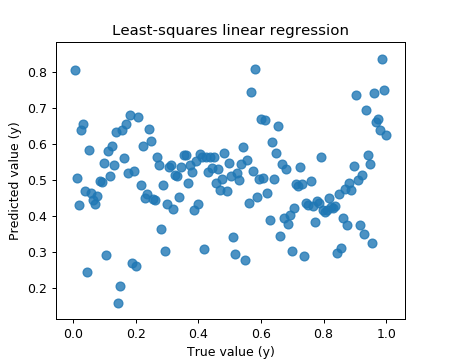

In [39]:
plt.figure(figsize=(5,4))
plt.scatter(y_test_nmpy, y_pred_model,marker= 'o', s=50, alpha=0.8)
#plt.plot(y_test_nmpy, y_pred_model, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('True value (y)')
plt.ylabel('Predicted value (y)')
plt.show()